# Libraries setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from unicodedata import normalize


import datetime
from datetime import date
%matplotlib inline

import re
import unicodedata
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_es = stopwords.words("english")

plt.style.use("ggplot")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sebastian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data

In [2]:
df = pd.read_csv('../datasets/upworthy-archive-exploratory-packages-03.12.2020.csv') 

In [3]:
print(df.dtypes)
df = df.iloc[:,1:] # remove the first columns, since is just the index
df.head()

Unnamed: 0                int64
created_at               object
updated_at               object
clickability_test_id     object
excerpt                  object
headline                 object
lede                     object
slug                     object
eyecatcher_id            object
impressions               int64
clicks                    int64
significance            float64
first_place                bool
winner                     bool
share_text               object
square                   object
test_week                 int64
dtype: object


,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week
0,2014-11-20 06:43:16.005,2016-04-02 16:33:38.062,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3052,150,100.0,True,True,Anyone who's ever felt guilty about shopping a...,NaN,201446
1,2014-11-20 06:43:44.646,2016-04-02 16:25:54.021,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3033,122,14.0,False,False,Walmart is getting schooled by another retaile...,NaN,201446
2,2014-11-20 06:44:59.804,2016-04-02 16:25:54.024,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3092,110,1.8,False,False,Walmart may not be crapping their pants over t...,NaN,201446
3,2014-11-20 06:54:36.335,2016-04-02 16:25:54.027,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546bc55335992b86c8000043,3526,90,4.1,False,False,"If you ever wondered, ""but what about the men?...",NaN,201446
4,2014-11-20 06:54:57.878,2016-04-02 16:31:45.671,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546d900426714cd2dd00002e,3506,120,100.0,True,False,"If you ever wondered, ""but what about the men?...",NaN,201446


In [4]:
idx = 4353
print(df.headline.values[idx])
print(df.excerpt.values[idx])

First You See Them Standing There Half-Naked. Then You Hear What They Say And It's Glorious.
Things that matter. Pass 'em on.


In [5]:
df = df.convert_dtypes()

date_format_columns = {dfc:np.datetime64 for dfc in ["created_at", "updated_at"]}
integer_columns = {ic:np.int64 for ic in ["clicks", "impressions", "significance", "test_week"]}  

df = df.astype(dict(date_format_columns, **integer_columns))
df.dtypes

created_at              datetime64[ns]
updated_at              datetime64[ns]
clickability_test_id            string
excerpt                         string
headline                        string
lede                            string
slug                            string
eyecatcher_id                   string
impressions                      int64
clicks                           int64
significance                     int64
first_place                    boolean
winner                         boolean
share_text                      string
square                          string
test_week                        int64
dtype: object

In [6]:
df.created_at.max()

Timestamp('2015-04-29 22:46:43.618000')

## Text preprocessing

In [7]:
from unicodedata import normalize

def preprocess_text(texts,
                    links=False,
                    hashtags_and_mentions=False,
                    stopwords=False,
                    tildes=True,
                    min_letters=0,
                    punctuation=True,
                    lower=True,
                    numbers=False):
    """
    Removes links, hashtags, mentions, stopweords, tildes, and numbers from given array of documents.
    """
    if lower:
      texts = map(lambda x: x.lower(), texts)
    if not links:
        #   Removing links
        links_regex = re.compile(r"http(s|)?:\/\/.*\s+")
        texts = np.array(
            list(map(lambda x: links_regex.sub("", x + " "), texts)))

    if not hashtags_and_mentions:
        hashtags_and_mentions_regex = re.compile(
            r"pic.twitter.com/(\w*)|#(\w+)|@(\w*)")
        texts = np.array(
            list(map(lambda x: hashtags_and_mentions_regex.sub("", x), texts)))

    if not stopwords:
        texts = np.array(
            list(
                map(
                    lambda x: ' '.join([
                        word for word in x.split() if word not in stopwords_es
                    ]), texts)))
    if min_letters > 0:
        texts = np.array(
            list(
                map(
                    lambda x: " ".join([
                        word for word in x.split() if len(word) > min_letters
                    ]), texts)))

    if not tildes:
        trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)
        texts = np.array(
            list(
                map(
                    lambda x: normalize(
                        'NFKC',
                        normalize('NFKD', x).translate(trans_tab)), texts)))

    if not punctuation:
      texts = np.array(list(map(lambda x: re.compile(r"[^\w\d'\s]+").sub(" ", x), texts)))
    if not numbers:
        texts = np.array(list(map(lambda x: re.sub(r"[0-9]", "", x), texts)))
    texts = np.array(
        list(map(lambda x: re.compile(r"\s{2,}").sub(" ", x), texts)))
    return texts

In [8]:
df[["processed_headline_nostpw"]] = df[["headline"]].apply(lambda x: preprocess_text(x.values, stopwords=False), axis=1, result_type="expand")
df[["processed_headline_stpw"]] = df[["headline"]].apply(lambda x: preprocess_text(x.values, stopwords=True), axis=1, result_type="expand")
df[["processed_headline_nostpw"]]

,processed_headline_nostpw
0,they're called 'walmart's worst nightmare.' *r...
1,they're called 'walmart's worst nightmare.' *r...
2,they're called 'walmart's worst nightmare.' *r...
3,sexism men sounds like
4,sexism men sounds like
...,...
22661,reasons may need plan vacation - right
22662,"next time encounter small minded bigot, tell t..."
22663,i've never wanted buy plane ticket hearing exp...
22664,ladies much fun epicenter disaster


In [9]:
df["headline_lowercase"] = df[["headline"]].apply(lambda x : np.array(list(map(lambda y: y.lower(), x.values))), axis=1, result_type="expand")
df.headline_lowercase

0        they're being called 'walmart's worst nightmar...
1        they're being called 'walmart's worst nightmar...
2        they're being called 'walmart's worst nightmar...
3              this is what sexism against men sounds like
4              this is what sexism against men sounds like
                               ...                        
22661    5 reasons you may need to plan a vacation - ri...
22662    the next time you encounter a small minded big...
22663    i've never wanted to buy a plane ticket more t...
22664    3 ladies having too much fun at the epicenter ...
22665    they're being called 'walmart's worst nightmar...
Name: headline_lowercase, Length: 22666, dtype: object

In [10]:
averaged_df = df.groupby(by="headline").sum().reset_index()
unique_df = pd.DataFrame(df["headline"].unique(), columns = ["headline"])
unique_df = unique_df.merge(averaged_df[["clicks", "impressions", "headline"]], how="inner", on=["headline"])
unique_df["click_rate"] = unique_df["impressions"] / unique_df["clicks"]
unique_df[["processed_headline_nostpw"]] = unique_df[["headline"]].apply(lambda x: preprocess_text(x.values, stopwords=False), axis=1, result_type="expand")
unique_df[["processed_headline_stpw"]] = unique_df[["headline"]].apply(lambda x: preprocess_text(x.values, stopwords=True), axis=1, result_type="expand")
unique_df

,headline,clicks,impressions,click_rate,processed_headline_nostpw,processed_headline_stpw
0,They're Being Called 'Walmart's Worst Nightmar...,514,12195,23.725681,they're called 'walmart's worst nightmare.' *r...,they're being called 'walmart's worst nightmar...
1,This Is What Sexism Against Men Sounds Like,784,30715,39.177296,sexism men sounds like,this is what sexism against men sounds like
2,Kim Jong Un Would Really Hate For You To Watch...,1391,41562,29.879224,kim jong un would really hate watch exactly,kim jong un would really hate for you to watch...
3,What They Learned From The Scientist Was Terri...,51,4594,90.078431,learned scientist terrifying. that's needed hear.,what they learned from the scientist was terri...
4,A Bunch Of Celebrities Recorded A Song To Rais...,769,15480,20.130039,bunch celebrities recorded song raise money eb...,a bunch of celebrities recorded a song to rais...
...,...,...,...,...,...,...
12382,"A Pen, Paper, And Watercolors Tell One Of The ...",21,1923,91.571429,"pen, paper, watercolors tell one tragic storie...","a pen, paper, and watercolors tell one of the ..."
12383,Newsflash: Black People Travel Too. Here's Why.,15,3575,238.333333,newsflash: black people travel too. here's why.,newsflash: black people travel too. here's why.
12384,5 Reasons You May Need To Plan A Vacation - Ri...,18,3724,206.888889,reasons may need plan vacation - right,reasons you may need to plan a vacation - rig...
12385,The Next Time You Encounter A Small Minded Big...,23,3728,162.086957,"next time encounter small minded bigot, tell t...",the next time you encounter a small minded big...


In [22]:
# df = pd.read_csv("11k.csv") 
once =  pd.read_csv('../datasets/11k.csv')
# df[df.headline.str.contains("Kim Jong")]
len(once.clickability_test_id.unique())

2607

In [39]:
df.duplicated().sum()

0

# Comparing two headlines

## Cleaning dataset

In [24]:
num_packages = len(df.clickability_test_id.unique())
print(f"There are {num_packages} number of packages")
comp_df = df.copy()

There are 4873 number of packages


In [25]:
num_headlines = len(comp_df.headline.unique())
print(f"There are {num_headlines} number of headlines")

There are 12387 number of headlines


In [26]:
df

,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week,processed_headline_nostpw,processed_headline_stpw,headline_lowercase
0,2014-11-20 06:43:16.005,2016-04-02 16:33:38.062,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3052,150,100,True,True,Anyone who's ever felt guilty about shopping a...,<NA>,201446,they're called 'walmart's worst nightmare.' *r...,they're being called 'walmart's worst nightmar...,they're being called 'walmart's worst nightmar...
1,2014-11-20 06:43:44.646,2016-04-02 16:25:54.021,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3033,122,14,False,False,Walmart is getting schooled by another retaile...,<NA>,201446,they're called 'walmart's worst nightmare.' *r...,they're being called 'walmart's worst nightmar...,they're being called 'walmart's worst nightmar...
2,2014-11-20 06:44:59.804,2016-04-02 16:25:54.024,546d88fb84ad38b2ce000024,Things that matter. Pass 'em on.,They're Being Called 'Walmart's Worst Nightmar...,"<p>When I saw *why* people are calling them ""W...",theyre-being-called-walmarts-worst-nightmare-a...,546d6fa19ad54eec8d00002d,3092,110,1,False,False,Walmart may not be crapping their pants over t...,<NA>,201446,they're called 'walmart's worst nightmare.' *r...,they're being called 'walmart's worst nightmar...,they're being called 'walmart's worst nightmar...
3,2014-11-20 06:54:36.335,2016-04-02 16:25:54.027,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546bc55335992b86c8000043,3526,90,4,False,False,"If you ever wondered, ""but what about the men?...",<NA>,201446,sexism men sounds like,this is what sexism against men sounds like,this is what sexism against men sounds like
4,2014-11-20 06:54:57.878,2016-04-02 16:31:45.671,546d902c26714c6c44000039,Things that matter. Pass 'em on.,This Is What Sexism Against Men Sounds Like,<p>DISCLOSURE: I'm a dude. I have cried on mul...,this-is-what-sexism-against-men-sounds-like-am...,546d900426714cd2dd00002e,3506,120,100,True,False,"If you ever wondered, ""but what about the men?...",<NA>,201446,sexism men sounds like,this is what sexism against men sounds like,this is what sexism against men sounds like
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22661,2014-11-20 01:21:49.197,2016-04-02 16:25:53.916,546d373426714cde76000018,Things that matter. Pass 'em on.,5 Reasons You May Need To Plan A Vacation - Ri...,<p>Travel isn't just a luxury or indulgence an...,5-reasons-you-may-need-to-plan-a-vacation-righ...,546d398a9ad54eec8d00000f,3724,18,0,True,False,<NA>,<NA>,201446,reasons may need plan vacation - right,reasons you may need to plan a vacation - rig...,5 reasons you may need to plan a vacation - ri...
22662,2014-11-20 01:23:31.203,2016-04-02 16:31:40.651,546d373426714cde76000018,Things that matter. Pass 'em on.,The Next Time You Encounter A Small Minded Big...,<p>Travel isn't just a luxury or indulgence an...,the-next-time-you-encounter-a-small-minded-big...,546d398a9ad54eec8d00000f,3728,23,0,False,False,<NA>,<NA>,201446,"next time encounter small minded bigot, tell t...",the next time you encounter a small minded big...,the next time you encounter a small minded big...
22663,2014-11-20 01:24:23.415,2016-04-02 16:31:50.079,546d373426714cde76000018,Things that matter. Pass 'em on.,I've Never Wanted To Buy A Plane Ticket More T...,<p>Travel isn't just a luxury or indulgence an...,ive-never-wanted-t

In [27]:
packages_df = comp_df.groupby("clickability_test_id").sum().reset_index(drop=False)
packages_df

,clickability_test_id,impressions,clicks,significance,first_place,winner,test_week
0,51436061220cb800020001e7,10380,219,172,1,1,805232
1,51436069220cb800020005ae,9797,111,101,1,1,1006555
2,51436069220cb800020005bd,10573,192,123,1,1,402610
3,5143606a220cb800020005c6,11079,152,101,1,1,805228
4,5143606b220cb800020005d7,11062,178,145,1,1,1006545
...,...,...,...,...,...,...,...
4868,554036c1393131000c330100,12236,52,215,1,0,1209102
4869,55403be0393131002cf60000,8178,29,110,1,0,806068
4870,55413ef4333531000c180000,4105,50,102,1,1,403034
4871,554141c4383063001c110000,10140,24,0,1,0,1007585


In [28]:
packages_df["num_unique_headlines"] = [len(comp_df[comp_df.clickability_test_id == id].headline.unique()) for id in packages_df.clickability_test_id] 
packages_df["num_total_headlines"] = [len(comp_df[comp_df.clickability_test_id == id].headline.values) for id in packages_df.clickability_test_id]
packages_df

,clickability_test_id,impressions,clicks,significance,first_place,winner,test_week,num_unique_headlines,num_total_headlines
0,51436061220cb800020001e7,10380,219,172,1,1,805232,4,4
1,51436069220cb800020005ae,9797,111,101,1,1,1006555,5,5
2,51436069220cb800020005bd,10573,192,123,1,1,402610,2,2
3,5143606a220cb800020005c6,11079,152,101,1,1,805228,4,4
4,5143606b220cb800020005d7,11062,178,145,1,1,1006545,5,5
...,...,...,...,...,...,...,...,...,...
4868,554036c1393131000c330100,12236,52,215,1,0,1209102,1,6
4869,55403be0393131002cf60000,8178,29,110,1,0,806068,4,4
4870,55413ef4333531000c180000,4105,50,102,1,1,403034,2,2
4871,554141c4383063001c110000,10140,24,0,1,0,1007585,1,5


#### How many packages have repeated headlines?

In [29]:
packages_df[packages_df.num_unique_headlines < packages_df.num_total_headlines]

,clickability_test_id,impressions,clicks,significance,first_place,winner,test_week,num_unique_headlines,num_total_headlines
5,5143606d220cb80002000643,16385,130,147,1,1,805616,1,4
14,51436074220cb800020007b2,10557,140,0,0,0,805236,3,4
18,51436079220cb800020008b8,10553,306,142,1,1,805216,3,4
19,5143607b220cb80002000918,17937,473,102,1,0,1409415,1,7
31,51436086220cb800020009a1,12211,323,129,1,1,805240,2,4
...,...,...,...,...,...,...,...,...,...
4865,553fdeee316638000cad0000,15215,44,255,1,0,1007585,1,5
4867,55400040396536001c4e0200,15213,42,436,1,0,1007585,1,5
4868,554036c1393131000c330100,12236,52,215,1,0,1209102,1,6
4871,554141c4383063001c110000,10140,24,0,1,0,1007585,1,5


In [30]:
2650 / 4873

0.5438128462959163

#### How many packages have more than a single package?

In [31]:
packages_df[packages_df["num_unique_headlines"] > 1]

,clickability_test_id,impressions,clicks,significance,first_place,winner,test_week,num_unique_headlines,num_total_headlines
0,51436061220cb800020001e7,10380,219,172,1,1,805232,4,4
1,51436069220cb800020005ae,9797,111,101,1,1,1006555,5,5
2,51436069220cb800020005bd,10573,192,123,1,1,402610,2,2
3,5143606a220cb800020005c6,11079,152,101,1,1,805228,4,4
4,5143606b220cb800020005d7,11062,178,145,1,1,1006545,5,5
...,...,...,...,...,...,...,...,...,...
4863,553fd64a356133000c450100,18252,73,280,1,0,1209102,6,6
4864,553fdd3c316638000c800000,18293,40,228,1,1,1209102,5,6
4866,553fdfd2316638000cbf0000,21296,153,263,1,1,1410619,7,7
4869,55403be0393131002cf60000,8178,29,110,1,0,806068,4,4


In [32]:
packages_ids = packages_df[packages_df["num_unique_headlines"] > 1].clickability_test_id.values
len(packages_ids)

2607

### 1. Removing duplicate headlnes 

In [33]:
sub_train_dfs = [df[df.clickability_test_id == id].drop_duplicates("headline") for id in packages_ids]

In [34]:
filtered_df = pd.concat(sub_train_dfs, ignore_index=True)
filtered_df

,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week,processed_headline_nostpw,processed_headline_stpw,headline_lowercase
0,2013-02-24 07:10:53.000,2016-04-02 16:24:07.081,51436061220cb800020001e7,Religion and science can indeed be friends.,Creationism Has Nothing To Do With Christianit...,"<p>In a debate about creationism, one guy got ...",creationism-has-nothing-to-do-with-christianit...,5332ba141fae79f09f002c4f,2551,39,0,False,False,<NA>,A_Priest_Ridicules_Creationist_-_YouTube.jpg,201308,creationism nothing christianity according chr...,creationism has nothing to do with christianit...,creationism has nothing to do with christianit...
1,2013-02-24 07:08:08.000,2016-04-02 16:26:25.064,51436061220cb800020001e7,"Good show, father.",The One Where A Creationist Picks A Fight And ...,"<p>In a debate about creationism, one guy got ...",the-one-where-a-creationist-picks-a-fight-and-...,5332ba141fae79f09f002c4f,2629,68,100,True,True,<NA>,A_Priest_Ridicules_Creationist_-_YouTube.jpg,201308,one creationist picks fight loses priest,the one where a creationist picks a fight and ...,the one where a creationist picks a fight and ...
2,2013-02-24 07:07:13.000,2016-04-02 16:26:28.801,51436061220cb800020001e7,Why is he wearing that costume?,Creationism Shouldn't Be Taught In Science Cla...,"<p>In a debate about creationism, one guy got ...",creationism-shouldnt-be-taught-in-science-clas...,5332ba141fae79f09f002c4f,2539,49,11,False,False,<NA>,A_Priest_Ridicules_Creationist_-_YouTube.jpg,201308,"creationism taught science classes, according ...",creationism shouldn't be taught in science cla...,creationism shouldn't be taught in science cla...
3,2013-02-24 07:09:18.000,2016-04-02 16:26:28.804,51436061220cb800020001e7,"Well played, God. Well played.",God Finds Out About Creationism And Sends A Re...,"<p>In a debate about creationism, one guy got ...",god-finds-out-about-creationism-and-sends-a-re...,5332ba141fae79f09f002c4f,2661,63,61,False,False,<NA>,A_Priest_Ridicules_Creationist_-_YouTube.jpg,201308,god finds creationism sends representative put...,god finds out about creationism and sends a re...,god finds out about creationism and sends a re...
4,2013-03-17 07:38:21.000,2016-04-02 16:24:11.525,51436069220cb800020005ae,"Honesty is so refreshing. Also, rude.",The One Where Your Advertisements Talk To You ...,Learn what advertisements say to each other be...,the-one-where-your-advertisements-talk-to-you-...,5332b5961fae79f09f000636,1950,15,0,False,False,<NA>,Screenshot_3_17_13_1_32_AM_MDT.jpg,201311,one advertisements talk like idiot,the one where your advertisements talk to you ...,the one where your advertisements talk to you ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11115,2015-04-29 02:03:57.892,2016-04-02 16:32:29.144,55403be0393131002cf60000,<NA>,"A plastic bottle finds its way home, along wit...",<p>There's something timeless about this story...,a-plastic-bottle-finds-its-way-home-along-with...,553a6c16646537000c210100,2094,5,3,False,False,<NA>,<NA>,201517,"plastic bottle finds way home, along powerful ...","a plastic bottle finds its way home, along wit...","a plastic bottle finds its way home, along wit..."
11116,2015-04-29 02:18:05.646,2016-04-02 16:32:29.121,55403be0393131002cf60000,<NA>,"A plastic bottle finds its way home, but its o...",<p>There's something timeless about this story...,a-plastic-bottle-finds-its-way-home-but-its-or...,553a6c16646537000c210100,2040,14,100,True,False,<NA>,<NA>,201517,"plastic bottle finds way home, original owner ...","a plastic bottle finds its way home, but its o...","a plastic bottle finds its way home, but its o..."
11117,2015-04-29 02:18:16.117,2016-04-02 16:32:29.124,55403be0393131002cf60000,<NA>,The epic journey of a plastic bottle shows us ...,<p>There's something timeless about this story...,the-epic-journey-of-a-plastic-bottle-shows-us-..

In [35]:
filtered_df.processed_headline_stpw.values[0:10].tolist()

['creationism has nothing to do with christianity according to christian dude ',
 'the one where a creationist picks a fight and loses to a priest ',
 "creationism shouldn't be taught in science classes, according to this guy. ",
 'god finds out about creationism and sends a representative to put a stop to it ',
 "the one where your advertisements talk to you like you're not an idiot for once ",
 'the advertisements you read every day, only naked ',
 "wouldn't it be great if ads told the truth? ",
 'what your advertisement say about you behind closed doors ',
 'what if advertisements just said what they meant? ',
 "mr. president, i'm not mad. i'm just disappointed. "]

In [36]:
packages_ids = filtered_df.clickability_test_id.values
packages_ids = np.array(packages_ids)
print(f"packages_ids: {packages_ids}\nlength: {len(packages_ids)}")

packages_ids: ['51436061220cb800020001e7' '51436061220cb800020001e7'
 '51436061220cb800020001e7' ... '55403be0393131002cf60000'
 '55413ef4333531000c180000' '55413ef4333531000c180000']
length: 11120


## Train and data partitioning

In [37]:
train_samples, val_samples, test_samples = list(map(lambda x : int(x * len(packages_ids)), (0.8, 0.1, 0.1))) 

train_package_ids = packages_ids[:train_samples]
val_package_ids = packages_ids[train_samples:train_samples+val_samples]
test_package_ids = packages_ids[-test_samples:]

print(train_package_ids.shape)
print(val_package_ids.shape)
print(test_package_ids.shape)

(8896,)
(1112,)
(1112,)


In [38]:
train_texts = np.array(df[df.clickability_test_id.isin(train_package_ids)]["processed_headline_stpw"].tolist())
train_texts

array(['why democracy loves social media ',
       'it’s the time of year people buy new cars, here’s the chart you need to see before you buy ',
       'this might seem overblown, but think deeply about it ', ...,
       'why this canadian restaurant wants you to order your food without speaking ',
       "you'll walk into this restaurant for food, and walk out with a specific new skill ",
       'what the waitstaff at one restaurant is teaching its customers - about ordering '],
      dtype='<U113')

In [44]:
import pickle 

once = pd.read_csv("../dataset/11k.csv")

dataset_with_features = {
    'df': once, 
    'train_package_ids': train_package_ids,
    'val_package_ids': val_package_ids,
    'test_package_ids': test_package_ids   
} 

with open("dataset_11k_features.pickle", 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

set()

In [ ]:
import pickle 

once = pd.read_csv("../dataset/11k.csv")

dataset_with_features = {
    'df': filtered_df, 
    'train_package_ids': train_package_ids,
    'val_package_ids': val_package_ids,
    'test_package_ids': test_package_ids   
} 

with open("dataset_11k_features.pickle", 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
once.clickability_test_id.values - filtered_df.clickability_test_id.valuess

{'547652863261310024cc0000',
 '53f7891a2193c57c2b000021',
 '536b64bc4e2f5acb40000068',
 '5240a74e4000b6002900bf46',
 '53878fc8d006a978a500001f',
 '53557f271b796920d400001a',
 '5383e42c80759fedda000002',
 '52e07978539305589c000001',
 '54459120271246c888000017',
 '53b5d170c9b3e57fa600007b',
 '543096087c2de7d7f800000d',
 '521aa7eaa0a111708b001f41',
 '51436093220cb80002000a29',
 '54d1967c63666200191c0000',
 '5330eb3800d2ea8cf0000004',
 '53eac9b4bf312285e5000063',
 '541a0fa92a027740b3000001',
 '54538bd00e46463514000048',
 '53da9dc4c8d9d17311000012',
 '543b55c6b47833584a000034',
 '52fe425b3b13681644000038',
 '542891dd389e1cb9b7000025',
 '53bb2fb61d9f3f370f000004',
 '53b8751b55a05de802000009',
 '532b59fae12aeb98a5000012',
 '535e6b45786e4fe2ce000057',
 '53861c5892398a206900001d',
 '528e8cc195eed00d8f000030',
 '530baf924f51b8d707000036',
 '52c1cb58af79e11ddb0008d8',
 '520e817d4d90d679250001bb',
 '540e2e50dc5dbf4a5200000b',
 '52ceebca09b58ff647002951',
 '542c3ac034120fc76500003e',
 '522bcee67797

## Model

In [ ]:
import pickle
with open('dataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

df = dataset["df"]
train_package_ids = dataset['train_package_ids']
val_package_ids = dataset['val_package_ids']
test_package_ids = dataset['test_package_ids']

train_texts = np.array(df[df.clickability_test_id.isin(train_package_ids)]["processed_headline_stpw"].tolist())
train_texts

array(['creationism has nothing to do with christianity according to christian dude ',
       'the one where a creationist picks a fight and loses to a priest ',
       "creationism shouldn't be taught in science classes, according to this guy. ",
       ...,
       "fed up with holiday shopping being rammed down your throat? here's an alternative. ",
       'how to take back thanksgiving weekend and actually enjoy it ',
       'how thanksgiving weekend can be about so much more than shopping '],
      dtype='<U113')

### Transfomer encoder

#### Positional encoding

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10000, 100)


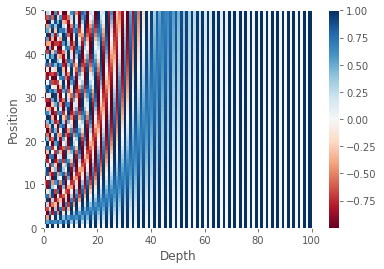

In [ ]:
pos = 10000
d_model = 100
pos_encoding = positional_encoding(pos, d_model)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0][:50,:], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Masks

padding_mask: [[[[0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0.]]]]


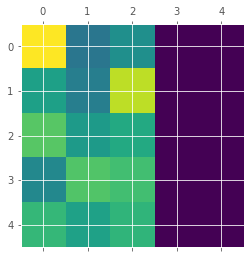

In [ ]:
def create_padding_mask(seq, padding_token=0):
  """
  Creates a mask with ones where padding_token is found and zeros elsewhere.
  This mask is added to the attention logits in order to prevent the 
  model to focus in padding tokens.

  Args:
    seq: tensor with shape (batch_size, maxlen)
    padding_token: token for padding, Default: 0.
  Returns:
    mask of shape (batch_size, 1, 1, maxlen)
  """
  seq = tf.cast(tf.math.equal(seq, padding_token), tf.float32)
  # add extra dimensions to add the padding
  # to the attention logits and match dimensions.
  mask = seq[:, tf.newaxis, tf.newaxis, :]
  return mask # (batch_size, 1, 1, maxlen)

tokens = tf.constant([[743, 623, 0, 0, 0], 
                 [132, 243, 453, 0, 0], 
                 [365, 400, 290, 265, 509]])
att_logits = tf.random.uniform((3,1,5,5)) # Simulate att logits (batch_size, num_heads, maxlen, maxlen)
padding_mask = create_padding_mask(tokens)
print(f"padding_mask: {padding_mask}")
masked_att_logits = att_logits + (padding_mask * -1e9)
att_weights =  tf.nn.softmax(masked_att_logits, axis=-1)
plt.matshow(att_weights[1,0,:,:].numpy())

look_ahead_mask: [[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]
combined_masks:[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]]]


 [[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]]


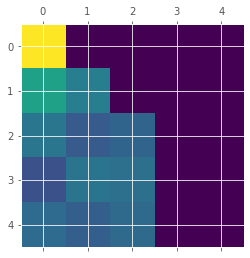

In [ ]:
def create_look_ahead_mask(maxlen, match_dims=False):
  """
  Creates mask to causal attention. 
  This mask will prevent the model to focus on future tokens.

  Args:
    maxlen: maxlen of the sequence
  Returns:
    Tensor of shape (maxlen, maxlen) with its upper filled with 
    ones and zeros elsewhere  
  """
  mask = 1 - tf.linalg.band_part(tf.ones((maxlen, maxlen)), -1, 0)
  if match_dims:
    mask = mask[tf.newaxis, tf.newaxis, :, :]
  return mask

padding_mask = create_padding_mask(tokens)
look_ahead_mask = create_look_ahead_mask(tokens.shape[1])
combined_masks = tf.maximum(padding_mask, look_ahead_mask)
print(f"look_ahead_mask: {look_ahead_mask}")
print(f"combined_masks:{combined_masks}")
masked_att_logits = att_logits + (combined_masks * -1e9)
att_weights =  tf.nn.softmax(masked_att_logits, axis=-1)

plt.matshow(att_weights[1,0,:,:].numpy()) # Visualize attention weights in first head for secod input 

#### MultiHeadAttention

In [ ]:
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        if d_model % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {d_model} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = d_model // num_heads

        self.query_dense = Dense(d_model)
        self.key_dense = Dense(d_model)
        self.value_dense = Dense(d_model)

        self.combine_heads = Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
      """
      Arguments:
        query: Query shape == (batch_size, num_heads, seq_len, projection_dim)
        key: Key shape == (batch_size, num_heads, seq_len, projection_dim)
        value: Value shape == (batch_size, num_heads, seq_len, projection_dim)

        Returns:
          output:            (batch_size, num_heads, seq_len, projection_dim) 
          attention_weights: (batch_size, num_heads, seq_len, seq_len)
      """
      dk = tf.cast(tf.shape(K)[-1], tf.float32)
      # (batch_size, num_heads, seq_len, seq_len)
      att_logits = tf.matmul(Q, K, transpose_b=True)
      scaled_att_logits = att_logits / tf.sqrt(dk) 
      if mask is not None:
        scaled_att_logits += (mask * -1e9)
      
      attention_weights = tf.nn.softmax(scaled_att_logits, axis=-1)
      # (batch_size, num_heads, seq_len, projection_dim)
      ooutput = attention_weights @ V
      return ooutput, attention_weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, Q, K, V, mask=None):
        """ 
          output, # (batch_size, seq_len, d_model) 
          weights # (batch_size, num_heads, seq_len, seq_len)
        """
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(Q)[0]
        query = self.query_dense(Q)  # (batch_size, seq_len, d_model)
        key = self.key_dense(K)  # (batch_size, seq_len, d_model)
        value = self.value_dense(V)  # (batch_size, seq_len, d_model)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.scaled_dot_product_attention(
            query, key, value, mask)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.d_model)
        )  # (batch_size, seq_len, d_model)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, num_heads, seq_len, seq_len)
        return output, weights 

(2, 1, 1, 5)


(TensorShape([2, 5, 100]), TensorShape([2, 5, 5, 5]))

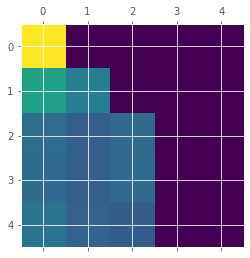

In [ ]:
mha = MultiHeadAttention(d_model=100, num_heads=5)

tokens = tf.constant([[1, 2, 0, 0, 0], 
                      [3, 4, 5, 0, 0]])
x = tf.random.uniform((tokens.shape[0], tokens.shape[1], 100))  # (batch_size, maxlen, d_model)

padding_mask = create_padding_mask(tokens)
look_ahead_mask = create_look_ahead_mask(tokens.shape[1])
combined_mask = tf.maximum(padding_mask, look_ahead_mask)

print(padding_mask.shape)
out, att_weights = mha(x,x,x, mask=combined_mask)
plt.matshow(att_weights[1,0,:,:]) # Visualize causal self-attention in the first head for the second sample 
out.shape, att_weights.shape

#### Transformer Encoder Layer

In [ ]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.2):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
                      Dense(ff_dim, activation="relu"), 
                      Dense(d_model),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
        """
        output # (batch_size, seq_len, d_model) 
        weights # (batch_size, num_heads, seq_len, seq_len)
        """
        attn_output, weights = self.mha(inputs, inputs, inputs, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)
        return output, weights

In [ ]:
transformer = TransformerEncoderLayer(100,5,64)
inputs = tf.random.uniform((1, 50, 100))  # (batch_size, encoder_sequence, d_model)
out, weights = transformer(inputs)
out.shape, weights.shape

(TensorShape([1, 50, 100]), TensorShape([1, 5, 50, 50]))

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, token_embedding):
    """ 
    Layer for converting tokens ids into embeddings with positional information encoded 
    and create padding and look ahead masks (optional) 
    
    Args:
      token_embedding(tf.keras.layers.Embedding): Embedding layer
    Returns:
      Embeddings with   
    """
    super(PositionalEmbedding, self).__init__()
    self.vocab_size = token_embedding.input_dim
    self.d_model = token_embedding.output_dim 
    self.maxlen = token_embedding.input_length
    self.token_emb = token_embedding
    self.pos_encoding = positional_encoding(self.vocab_size, self.d_model)

  def call(self, input_tokens, training, causal_attention=False):
    """ 
    Computes embeddings for input tokens ids and apply them positional encoding
    Args:
      x (tensor): tensor with shape (batch_size, maxlen)
      causal_attention(bool): If True, padding mask is combined with look ahead mask. 
                              Otherwise only padding mask is created. 

    Returns:
      x: Positional encoded embeddings 
      mask: Padding mask for Multi Head Attention (with lookahead, optionally)
    """
    maxlen = tf.shape(input_tokens)[-1]
    mask = create_padding_mask(input_tokens)
    if causal_attention:
      look_ahead_mask = create_look_ahead_mask(maxlen)
      mask = tf.maximum(mask, look_ahead_mask)

    x = self.token_emb(input_tokens, training=training)  # (batch_size, maxlen, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :maxlen, :]
    return x, mask

In [ ]:
class TransformerEncoder(tf.keras.models.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, embedding_layer, 
               causal_attention=False, dropout_rate=0.2):
    super(TransformerEncoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding_layer = embedding_layer
    self.encoder_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate=dropout_rate) 
                           for _ in range(num_layers)]
    assert d_model == self.embedding_layer.output_dim, f"d_model and embedding output dim must be equal, {d_model} != {self.embedding_layer.output_dim}"
    self.positional_embedding = PositionalEmbedding(self.embedding_layer)
    self.causal_attention = causal_attention
    self.dropout = Dropout(dropout_rate)
    
  def call(self, input_tokens, training):
    """
    Args:
      input_tokens: tensor with shape (batch_size, maxlen) of tokens
    Returns:
      x: (batch_size, input_seq_len, d_model)
      layers_att_weights: dictionary with layer names as keys and 
                          attention weights of shape (batch_size, num_heads, maxlen, maxlen) 
                          for each layer as values 
    """
    embeddings, mask = self.positional_embedding(input_tokens, training=training, 
                                                 causal_attention=self.causal_attention)
    
    x = self.dropout(embeddings, training=training)
    
    layers_att_weights = {}

    for i in range(self.num_layers):
      x, weights = self.encoder_layers[i](x, training, mask)
      layers_att_weights[f"encoder_layer_{i+1}"] = weights
    return x, layers_att_weights

# Training transformer model

## Data generator

In [ ]:
from IPython.display import display
from pprint import pprint

@tf.autograph.experimental.do_not_convert
def single_data_generator(packages_ids, one_hot=False, classification=True, 
                          regression=False, sorted=False, cased=False,
                          features=None, enforced=False, isolate=None):
  """ 
  Yields a single training sample according to calssification or regression task.
  
  Arguments:
    packages_ids: list or numpy array. List of packages ids where pairs of 
                  headlines will be taken randomly
    one_hot: bool, whether to one hot encode class labels. Only valid if 
             classification = True, otherwise a ValueError will be raised
    classification: bool, whether to yield labels as a binary classification task. 
                    1 ([0, 1] if one_hot=True) if first headline had more clicks than 
                    the second headline, 0 ([1, 0] if one_hot=True) otherwise.

    regression: bool, whether to yield targets as a regression task. 
                The regression is calculated as follows:

                abs(num_clicks_in_headline_1 - num_clicks_in_headline_2) / 
                          maximum_number_of_clicks_in_package
    
    regression and classification are not mutually exclusive, if both are set 
    to True, then a tuple with 

    sorted: If True, yielded headlines will be sorted descendently by number of clicks. 
            Otherwise, yielded headlines will not have any particular order
    
    cased: If True, yielded headlines will not be lowercased. 
           Otherwise, all headlines will be lowercased, 
    
    features: default to None. List of names of the variables to include as features in df; 
              yielded elements will include a vector with the values of the features specified for each headline. 
              
              Concretely:

                (headline0, *features0, headline1, *features1, regression, classification) is yielded           
              
              Otherwise, if features=None (default):

                (headline1, headline2, regression, classification | regression) is yielded
    
    enforced: If True, then the same pair of headlines are yielded twice, 
              but the second pair is swapped  with labels and features (if valid) 
              changed accordingly.
    ## TODO
    isolate: Defaults to None. If different than None, then yields a string 
             which only has distinct words between two headlines and the other 
             tokens are padded with a isolate string 
    
  """
  if not classification and not regression:
    raise ValueError("Output must be either classification or regresion (not exclusive)")
  if one_hot and not classification:
    raise ValueError("One hot encoding is only allowed in classification mode") 
  if isolate != None and type(isolate) != str :
    raise ValueError("Isolate can only be a string")

  while True:
    idx = np.squeeze(np.random.choice(len(packages_ids), 1, replace=False))
    chosen_package_id = str(packages_ids[idx])
    package = df[df["clickability_test_id"] == chosen_package_id]
    random_headline_idxs = np.random.choice(len(package), 2, replace=False)
    y_raw = package.clicks.values[random_headline_idxs]
    
    # Skip if both headlines have the same number of clicks
    if y_raw[0] == y_raw[1]:
      continue
    
    # Get both headlines
    if not cased:
      h1, h2 = package["headline_lowercase"].values[random_headline_idxs].tolist()
    else:
      h1, h2 = package["headline"].values[random_headline_idxs].tolist()
    
    # Skip if both headlines are the same
    if h1 == h2:
      continue

    label = int(y_raw[0] > y_raw[1]) 
    
    y_classification = -1
    y_regression = -1

    if classification:
      y_classification = np.eye(2)[label] if one_hot else label
    
    if regression:
      y_regression = np.abs(np.subtract(*y_raw) / package.clicks.max())
    
    if sorted:      
      headlines = (h1, h2) if label else (h2, h1)
    else:
      headlines = (h1, h2)
    if not enforced:
      inputs = (headlines[0], headlines[1], y_regression, y_classification) 
      if features != None:
        features_h0, features_h1  = package[features].values[random_headline_idxs]
        inputs = (headlines[0], *features_h0, headlines[1], *features_h1, y_regression, y_classification)
      yield inputs
    else:
      swapped_yclassification = int(not y_classification if y_classification != -1  else y_classification)
      inputs1 = (headlines[0], headlines[1], y_regression, y_classification) 
      inputs2 = (headlines[1], headlines[0], y_regression, swapped_yclassification)
      if features != None:
        features_h0, features_h1  = package[features].values[random_headline_idxs]
        inputs1 = (headlines[0], *features_h0, headlines[1], *features_h1, y_regression, y_classification)
        inputs2 = (headlines[1], *features_h1, headlines[0], *features_h0, y_regression, swapped_yclassification) #Swapped
      for inputs in [inputs1, inputs2]:
        yield inputs

i = 0
for x in single_data_generator(train_package_ids, regression=False, 
                              classification=True, cased=True, 
                              sorted=False, enforced=True, 
                              isolate=None, features=None): 
  if i < 4:
    pprint(x)
    pprint(len(x))
  else:
    break
  i+=1

("Gah! Hearing 'Irreplaceable' With This Emotion Brings An Entirely New "
 'Perspective To The Song.',
 "Hearing Beyonce's Words Spoken Just May Make You Hear Her Song In A Brand "
 'New Feminist Way',
 -1,
 0)
4
("Hearing Beyonce's Words Spoken Just May Make You Hear Her Song In A Brand "
 'New Feminist Way',
 "Gah! Hearing 'Irreplaceable' With This Emotion Brings An Entirely New "
 'Perspective To The Song.',
 -1,
 1)
4
("They're Giving Kids Around The World Some Interesting Tools. Let's See What "
 'They Build.',
 "They Calling It 'Reweaving', But The Plan Is Basically Just To Let Kids Be "
 'Incredible',
 -1,
 0)
4
("They Calling It 'Reweaving', But The Plan Is Basically Just To Let Kids Be "
 'Incredible',
 "They're Giving Kids Around The World Some Interesting Tools. Let's See What "
 'They Build.',
 -1,
 1)
4


## Fit texts with BytePairEncoding

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorboard
import matplotlib
import numpy as np
import pandas as pd

modules = [tf, tensorboard, matplotlib, np, pd]
for m in modules:
    print(f"{m.__name__}=={m.__version__}")
!python3 --version

tensorflow==2.4.0
tensorboard==2.4.0
matplotlib==3.2.2
numpy==1.19.5
pandas==1.1.5
Python 3.6.9


In [ ]:
from bpemb import BPEmb
bpemb_en = BPEmb(lang="en", vs=10000, dim=100)

In [ ]:
bpemb_en.vectors

array([[ 0.284519,  0.002012,  0.321941, ..., -1.068362, -0.406044,
        -0.431837],
       [-0.020818,  0.175859, -0.178794, ..., -0.140713,  0.146367,
         0.073685],
       [-0.062481, -0.072726, -0.035874, ...,  0.147668, -0.012654,
         0.042021],
       ...,
       [-0.079659,  0.271428, -0.306628, ..., -0.430938, -0.202792,
         0.035773],
       [ 0.27919 , -0.472931,  0.518207, ..., -1.274834,  0.013896,
         0.733151],
       [ 0.472254,  0.539463,  0.669444, ..., -1.177747, -0.196078,
        -0.362885]], dtype=float32)

In [ ]:
max([len(bpemb_en.encode_ids(h)) for h in train_texts])

42

In [ ]:
maxlen = 45

embeddings_layer = tf.keras.layers.Embedding(
    input_dim = bpemb_en.vectors.shape[0],
    output_dim = bpemb_en.vectors.shape[1],
    input_length = maxlen,
    embeddings_initializer = tf.keras.initializers.Constant(bpemb_en.vectors),
    trainable=False
)

In [ ]:
sample_enc = TransformerEncoder(1, 100, 5, 64, embeddings_layer, causal_attention = True)

tokens = bpemb_en.encode_ids(train_texts[0])
tokens += ([0] * (maxlen - len(tokens)))
tokens = tf.expand_dims(np.array(tokens), axis=0)
out, att_ws = sample_enc(tokens)
print(out.shape)
print(att_ws.keys())
print(list(att_ws.values())[0].shape)

(1, 45, 100)
dict_keys(['encoder_layer_1'])
(1, 5, 45, 45)


In [ ]:
tokenizer = tf.keras.layers.Lambda(lambda x: bpemb_en.encode_ids(x))
nonsense = np.random.choice(train_texts, size=1)[0]
print(nonsense)
print(bpemb_en.encode(nonsense))
print(bpemb_en.encode_ids(nonsense)) 
tokens = tokenizer(nonsense)
padded_tokens = tokens + [0] * (maxlen - len(tokens))
embedding_from_layer = embeddings_layer(np.array(tokens)).numpy() 
embeddings_from_lib = bpemb_en.embed(nonsense)
print(f'Embeddings from library and layer are equal? {np.allclose(embedding_from_layer,embeddings_from_lib)}')

when this city failed to make a connection, this -year old took it to the streets 
['▁when', '▁this', '▁city', '▁failed', '▁to', '▁make', '▁a', '▁connection', ',', '▁this', '▁-', 'year', '▁old', '▁took', '▁it', '▁to', '▁the', '▁streets']
[391, 215, 470, 3375, 42, 1166, 4, 4928, 9934, 215, 451, 2162, 749, 1276, 107, 42, 7, 5455]
Embeddings from library and layer are equal? True


In [ ]:
@tf.function
def filter_label_and_tokenize(h1, h2,y_reg, y_class):
  tokens1, tokens2 = list(map(bpemb_en.encode_ids, [h1, h2]))
  pad = lambda x : x + [0] * (maxlen - len(x))
  h1 = tf.constant(pad(tokens1), dtype=tf.int32, shape=(maxlen,))
  h2 = tf.constant(pad(tokens2), dtype=tf.int32, shape=(maxlen,))
  return h1,h2,y_class

filter_label_and_tokenize(train_texts[10], train_texts[1], 0, 1)

(<tf.Tensor: shape=(45,), dtype=int32, numpy=
 array([2927, 9935,  985, 9934,  386, 9937, 9927,  216, 2389, 9935,  386,
        9937, 9927, 1025,  332, 8332, 1701, 9935,  467, 9934, 9583, 9935,
         386, 9937, 9927,    4, 1885, 2389, 2586, 9935,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32)>, <tf.Tensor: shape=(45,), dtype=int32, numpy=
 array([   7,  272,  571,    4, 3976,  105,   24, 4376,    4, 2014,   34,
        1374,   29,   42,    4, 4690,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0], dtype=int32)>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)

In [ ]:
def get_datasets_for_transformer(train_package_ids, val_package_ids, test_package_ids, batch_sizes, one_hot=False,
                 classification=True, regression=False, sorted=False, cased=False, enforced=False):
  kwargs = {
    "one_hot": one_hot,
    "classification": classification,
    "regression": regression,
    "sorted": sorted,
    "features" : None,
    "cased": cased,
    "enforced": enforced
  }
  
  def filter_label_and_tokenize(h1, h2, y_reg, y_class):
    tokens1, tokens2 = list(map(bpemb_en.encode_ids, [h1, h2]))
    pad = lambda x : x + [0] * (maxlen - len(x))

    h1 = pad(tokens1)
    h2 = pad(tokens2)
    
    inputs = {
        "input_tokens_h1" : h1,
        "input_tokens_h2" : h2
    }
    return inputs, y_class

  def single_data_generator_wrapper(ids, **kwargs):
    generator = single_data_generator(ids, **kwargs) 
    for inputs in generator:
        inputs, y_class = filter_label_and_tokenize(*inputs)
        yield inputs, y_class

  def train_generator():
    return single_data_generator_wrapper(train_package_ids, **kwargs)
  
  def val_generator():
    kwargs["enforced"] = False
    return single_data_generator_wrapper(val_package_ids, **kwargs)

  def test_generator():
    kwargs["enforced"] = False
    return single_data_generator_wrapper(test_package_ids, **kwargs)

  output_signature = ({
        "input_tokens_h1": tf.TensorSpec(shape=(maxlen,), dtype=tf.int32), 
        "input_tokens_h2": tf.TensorSpec(shape=(maxlen,), dtype=tf.int32)          
      },
      tf.TensorSpec(shape=(), dtype=tf.int32)
  )

  kwarg = {'output_signature': output_signature}
  
  train_data = tf.data.Dataset.from_generator(train_generator, **kwarg)\
                              .prefetch(tf.data.AUTOTUNE).batch(batch_sizes["train"])
  
  val_data = tf.data.Dataset.from_generator(val_generator, **kwarg)\
                            .prefetch(tf.data.AUTOTUNE)\
                            .batch(batch_sizes["val"])
  
  test_data = tf.data.Dataset.from_generator(test_generator, **kwarg)\
                             .prefetch(tf.data.AUTOTUNE).batch(batch_sizes["test"])
  
  return (train_data, val_data, test_data)

batch_sizes = {
  'train': 2024,
  'val': 512,
  'test': 512
}

(train_data, val_data, test_data) = get_datasets_for_transformer(train_package_ids, val_package_ids, 
                                                 test_package_ids, classification = True, batch_sizes=batch_sizes,
                                                 enforced=True, regression = False)

print(next(iter(train_data)))

({'input_tokens_h1': <tf.Tensor: shape=(2024, 45), dtype=int32, numpy=
array([[ 121, 5139, 5451, ...,    0,    0,    0],
       [ 121, 8899,   74, ...,    0,    0,    0],
       [   7, 2820, 2066, ...,    0,    0,    0],
       ...,
       [   7,  784,   80, ...,    0,    0,    0],
       [6313, 3041, 9937, ...,    0,    0,    0],
       [6313, 3041, 9937, ...,    0,    0,    0]], dtype=int32)>, 'input_tokens_h2': <tf.Tensor: shape=(2024, 45), dtype=int32, numpy=
array([[ 121, 8899,   74, ...,    0,    0,    0],
       [ 121, 5139, 5451, ...,    0,    0,    0],
       [  13,  801, 9934, ...,    0,    0,    0],
       ...,
       [ 415, 9937,   12, ...,    0,    0,    0],
       [6313, 3041, 9937, ...,    0,    0,    0],
       [6313, 3041, 9937, ...,    0,    0,    0]], dtype=int32)>}, <tf.Tensor: shape=(2024,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 0, 1], dtype=int32)>)


### Embedder model 

#### Example of scaled dot product attention

In [ ]:
np.set_printoptions(suppress=False)

def scaled_dot_product_att(q, k, v):
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  attention_weights = tf.nn.softmax( tf.matmul(q, k, transpose_b=True) / tf.sqrt(dk))
  output = attention_weights @ v
  return output, attention_weights

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

# temp_v = tf.constant([[   1,0],
#                       [  10,0],
#                       [ 100,5],
#                       [1000,6]], dtype=tf.float32)  # (4, 2)

# temp_q = tf.constant([[0, 0, 10], # Aligns exactly with third and last row of keys
#                       [0, 10, 0], # Aligns exactly with second row of keys 
#                       [10, 10, 0]], dtype=tf.float32)  # (3, 3)

output, att_weights = scaled_dot_product_att(temp_k, temp_k, temp_k)
att_weights

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1.000000e+00, 8.433274e-26, 8.433274e-26, 8.433274e-26],
       [8.433274e-26, 1.000000e+00, 8.433274e-26, 8.433274e-26],
       [4.216637e-26, 4.216637e-26, 5.000000e-01, 5.000000e-01],
       [4.216637e-26, 4.216637e-26, 5.000000e-01, 5.000000e-01]],
      dtype=float32)>

#### Transformer embedder model architecture

In [ ]:
class TransfomerEmbedder(tf.keras.models.Model):
  def __init__(self, d_model, num_heads, dff, embedding_layer, 
               use_causal_attention=False, num_layers=1, dropout_rate=0.2):
    super(TransfomerEmbedder, self).__init__()
    self.num_heads = num_heads
    self.num_layers = num_layers
    self.transformer_encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, 
                                                  embedding_layer, use_causal_attention, dropout_rate)
    self.global_max_pool_1d = tf.keras.layers.GlobalMaxPool1D(name="global_max_pool_1d")

  def call(self, input_tokens, training):
    transformer_embeddings, attention_weights = self.transformer_encoder(input_tokens, training)
    return self.global_max_pool_1d(transformer_embeddings), attention_weights

In [ ]:
tf.keras.backend.clear_session()

transformer_embedder = TransfomerEmbedder(embeddings_layer.output_dim, num_heads=2, dff=512, embedding_layer=embeddings_layer, 
                                           use_causal_attention=False, num_layers=1, dropout_rate=0.2)

def get_classifier(transformer_embedder, dropout_rate=0.2):
  input_h1 = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32, name="input_tokens_h1")
  
  input_h2 = tf.keras.layers.Input(shape=(maxlen,), dtype=tf.int32, name="input_tokens_h2")
  
  embeddings_h1, attention = transformer_embedder(input_h1)

  embeddings_h2, attention = transformer_embedder(input_h2)

  concat = tf.keras.layers.Concatenate()([embeddings_h1, embeddings_h2])

  dropout1 = tf.keras.layers.Dropout(dropout_rate)(concat)

  # output_regression = tf.keras.layers.Dense(1, activation="linear", name="reg")(dropout1)

  output_classification = tf.keras.layers.Dense(1, activation="sigmoid", name="class")(dropout1)

  model = tf.keras.models.Model(inputs = {
      "input_tokens_h1": input_h1,
      "input_tokens_h2": input_h2,
  }, outputs=output_classification, name="model")
  return model

classifier = get_classifier(transformer_embedder)
classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_tokens_h1 (InputLayer)    [(None, 45)]         0                                            
__________________________________________________________________________________________________
input_tokens_h2 (InputLayer)    [(None, 45)]         0                                            
__________________________________________________________________________________________________
transfomer_embedder (Transfomer ((None, 100), {'enco 1143812     input_tokens_h1[0][0]            
                                                                 input_tokens_h2[0][0]            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 200)          0           transfomer_embedder[0][0]    

In [ ]:
def plot_attention_weights(transformer_embedder, encoded_sentences_tokens, token_decoder, layer="encoder_layer_1"):
  """ 
  Plots self-attention weights for each head in the Transformer Embedder

  Arguments:
     transformer_embedder: TransformerEmbedder
     encoded_sentences_tokens: ndarray (n, maxlen) of tokens where n is the number of headlines
     token_decoder: function that inputs a token and returns its corresponding word 

  Returns:
    A matplotlib Figure object with subplots of dimensions (N sentences, num_heads)
    where each plot is a heatmap of attention weights 
  """
  num_heads = transformer_embedder.num_heads
  # number of headlines
  n = int(tf.shape(encoded_sentences_tokens)[0]) 

  _, att_weights = transformer_embedder(encoded_sentences_tokens) # (n or batch_size, num_heads, maxlen, maxlen)
  att_weights = att_weights[layer]

  fig, axs = plt.subplots(nrows=n, ncols=num_heads, figsize=(4*num_heads, 4*n))
  fig.suptitle("Attention weights learned for each headline (winner headline in red)")

  for ith_headline in range(n):
    for jth_head in range(num_heads):
      
      # Don't consider padding tokens for visualize attention weights
      unpadded_tokens = list(filter(lambda x: x != 0, encoded_sentences_tokens[ith_headline,:]))
      decoded_subwords = [token_decoder(token) for token in unpadded_tokens]
      non_padding_tokens_len = len(decoded_subwords)

      # plot the attention weights
      ax = axs[ith_headline, jth_head] if n > 1 else axs[jth_head]  
      att = att_weights[ith_headline, jth_head, :non_padding_tokens_len, :non_padding_tokens_len]
      ax.matshow(att, cmap='viridis')

      fontdict = {'fontsize': 8}

      ax.set_xticks(range(non_padding_tokens_len))
      ax.set_yticks(range(non_padding_tokens_len))
      # ax.set_ylim(non_padding_tokens_len, -0.5)
      ax.set_xticklabels(decoded_subwords, fontdict=fontdict, rotation=90)
      ax.set_yticklabels(decoded_subwords, fontdict=fontdict)
      ax.set_xlabel('Head {}'.format(jth_head+1))

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  return fig

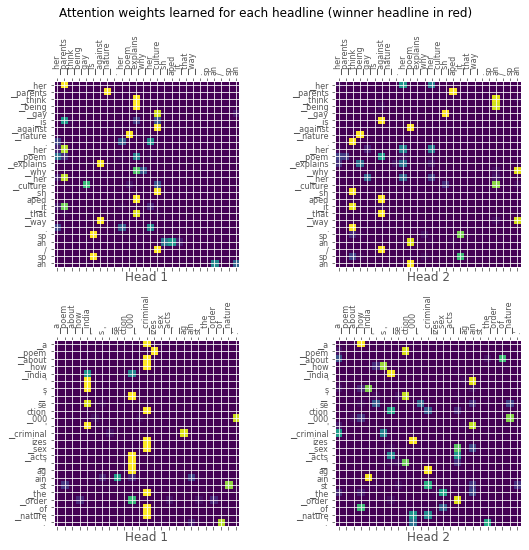

In [ ]:
for inputs, labels  in test_data.unbatch().batch(1).as_numpy_iterator():
  headline_ids = inputs['input_tokens_h1']
  headline_ids2 = inputs['input_tokens_h2']
  headline_pairs = tf.concat([headline_ids, headline_ids2], axis=0)
  # headlines_str = bpemb_decoder(headline_ids) 
  # print(headlines_str)
  # print(headline_ids.shape)
  # flattended, attention_weights = transformer_embedding(headline_ids, training=False) 
  # print(attention_weights.shape)
  fig = plot_attention_weights(transformer_embedder, headline_pairs, 
                               lambda token: bpemb_en.words[token], layer="encoder_layer_1")
  fig.show()
  break

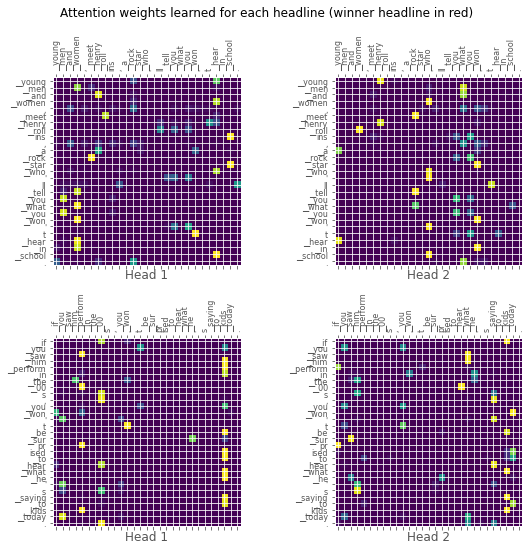

In [ ]:
fig = plot_attention_weights(transformer_embedder, headline_pairs, lambda token: bpemb_en.words[token], layer="encoder_layer_1")
fig.show()

In [ ]:
classifier.compile(optimizer="adam", loss="bce", metrics=["acc",tf.keras.metrics.AUC()])

In [ ]:
classifier.predict(train_data.take(1))

array([[0.09909746],
       [0.05496207],
       [0.03577992],
       ...,
       [0.08159477],
       [0.22279519],
       [0.15223157]], dtype=float32)

In [ ]:
train_steps = ((len(train_package_ids) * 2) // batch_sizes["train"])
val_steps = len(val_package_ids) // batch_sizes["val"]
test_stpes = len(test_package_ids) // batch_sizes["test"]

name_func = lambda x,y : f"{x} has {y} number of samples"
print(name_func("training", train_steps))
print(name_func("valdiation",val_steps))
print(name_func("testing",test_stpes))

training has 8 number of samples
valdiation has 2 number of samples
testing has 2 number of samples


In [ ]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

classifier.fit(
    train_data,
    steps_per_epoch = train_steps,
    validation_data = val_data,
    validation_steps= val_steps,
    epochs= epochs,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/100
8/8 [==============================] - 89s 11s/step - loss: 1.1222 - acc: 0.5047 - auc: 0.5070 - val_loss: 0.7383 - val_acc: 0.4912 - val_auc: 0.4908
Epoch 2/100
8/8 [==============================] - 83s 10s/step - loss: 0.8834 - acc: 0.5050 - auc: 0.5105 - val_loss: 0.9924 - val_acc: 0.4805 - val_auc: 0.5187
Epoch 3/100
8/8 [==============================] - 84s 11s/step - loss: 0.8032 - acc: 0.5083 - auc: 0.5107 - val_loss: 0.7985 - val_acc: 0.4658 - val_auc: 0.5557
Epoch 4/100
8/8 [==============================] - 86s 11s/step - loss: 0.7659 - acc: 0.5127 - auc: 0.5161 - val_loss: 0.8773 - val_acc: 0.5068 - val_auc: 0.5504
Epoch 5/100
8/8 [==============================] - 88s 11s/step - loss: 0.7458 - acc: 0.5080 - auc: 0.5148 - val_loss: 0.7873 - val_acc: 0.5303 - val_auc: 0.5546
Epoch 6/100
8/8 [==============================] - 83s 11s/step - loss: 0.7257 - acc: 0.5201 - auc: 0.5285 - val_loss: 0.8600 - val_acc: 0.4824 - val_auc: 0.5775


# BERT

## Downloading dependencies

In [ ]:
!nvidia-smi 

Sat Dec 26 17:17:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |    231MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tensorflow==2.3.0
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 460kB 35.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2319/2319), done.
remote: Total 2650 (delta 511), reused 1351 (delta 298), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (511/511), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by perfo

In [ ]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 215kB 11.1MB/s 
     |████████████████████████████████| 14.5MB 249kB/s 
     |████████████████████████████████| 296kB 56.3MB/s 
     |████████████████████████████████| 102kB 14.7MB/s 
     |████████████████████████████████| 25.9MB 94kB/s 
     |████████████████████████████████| 174kB 55.5MB/s 
     |████████████████████████████████| 3.6MB 43.9MB/s 
     |████████████████████████████████| 706kB 51.1MB/s 
     |████████████████████████████████| 358kB 50.3MB/s 
     |████████████████████████████████| 1.1MB 51.6MB/s 
     |████████████████████████████████| 11.6MB 212kB/s 
     |████████████████████████████████| 36.7MB 88kB/s 
     |████████████████████████████████| 276kB 38.3MB/s 
     |████████████████████████████████| 2.2MB 51.7MB/s 
     |████████████████████████████████| 92kB 12.2MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 81kB 6.3MB/s 
E

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.10.0
GPU is available


In [ ]:
# Max length
max([len(x.split()) for x in filtered_df["headline_lowercase"].values]) 

24

In [ ]:
from pprint import pprint 
pprint(df.columns)
dimensions = ['conflict', 'social_support', 'trust', 'fun', 'similarity', 'identity', 'respect', 'romance', 'knowledge', 'power']
features = ["headline_sentiment", "headline_nouns_count", "headline_verbs_count", "headline_adjectives_count", "headline_entities_count"] + dimensions
print(f"NUmber of dimensions: {len(dimensions)}")
print(f"Total features: {len(features)}")

Index(['Unnamed: 0', 'created_at', 'updated_at', 'clickability_test_id',
       'excerpt', 'headline', 'lede', 'slug', 'eyecatcher_id', 'impressions',
       'clicks', 'significance', 'first_place', 'winner', 'share_text',
       'square', 'test_week', 'processed_headline_nostpw',
       'processed_headline_stpw', 'headline_lowercase', 'headline_sentiment',
       'headline_nouns', 'headline_nouns_count', 'headline_verbs',
       'headline_verbs_count', 'headline_adjectives',
       'headline_adjectives_count', 'headline_entities',
       'headline_entities_count', 'conflict', 'social_support', 'trust', 'fun',
       'similarity', 'identity', 'respect', 'romance', 'knowledge', 'power'],
      dtype='object')
NUmber of dimensions: 10
Total features: 15


In [ ]:
c1, c2 = df[features].values[[1,2]]
c1

array([0.00781393, 3.        , 2.        , 0.        , 1.        ,
       0.51      , 0.53      , 0.34      , 0.71      , 0.18      ,
       0.21      , 0.43      , 0.43      , 0.4       , 0.44      ])

## Text preprocessing

In [ ]:
def get_datasets(train_package_ids, val_package_ids, test_package_ids, one_hot=False,
                 classification=True, regression=False, sorted=False, 
                 features=None, cased=False, enforced=False):
  kwargs = {
    "one_hot": one_hot,
    "classification": classification,
    "regression": regression,
    "sorted": sorted,
    "features" : features,
    "cased": cased,
    "enforced":enforced
  }

  with tf.device("/cpu:0"):
    
    def train_generator():
      return single_data_generator(train_package_ids, **kwargs)
    
    def val_generator():
      return single_data_generator(val_package_ids, **kwargs)

    def test_generator():
      return single_data_generator(test_package_ids, **kwargs)
    if features != None:
      output_types = [tf.string] + [tf.float32] * len(features) + [tf.string] + \
                   [tf.float32]*len(features) + [tf.float32, tf.int32] 
      output_types = tuple(output_types)
    else:
      output_types = (tf.string, tf.string, tf.float32, tf.int32)
    train_data = tf.data.Dataset.from_generator(train_generator, output_types)
    val_data = tf.data.Dataset.from_generator(val_generator, output_types)
    test_data = tf.data.Dataset.from_generator(test_generator, output_types)
  return (train_data, val_data, test_data)

In [ ]:
(train_data, val_data, test_data) = get_datasets(train_package_ids, val_package_ids, test_package_ids, classification = True, regression = False, features=features)
for xsys in zip(train_data.take(1).as_numpy_iterator(), val_data.take(1).as_numpy_iterator(), test_data.take(1).as_numpy_iterator()):
  list(map(lambda xy, title: print(f"{title} sample batch: {xy}"), *[xsys, ["Train", "Validation", "Test"]]))

Train sample batch: (b'this female gang attack sexual predators and rapists. tell me, what else can they do?', 0.02735442, 5.0, 3.0, 1.0, 0.0, 0.54, 0.3, 0.03, 0.83, 0.0, 0.2, 0.23, 0.91, 0.25, 0.67, b'men who abuse women, be afraid of this gang dressed in pink and armed with sticks', 0.0039623976, 7.0, 1.0, 1.0, 0.0, 0.46, 0.56, 0.1, 0.38, 0.0, 0.23, 0.54, 0.78, 0.3, 0.42, -1.0, 1)
Validation sample batch: (b'8 gay things we were taught as a 90s kid', 0.0013673902, 2.0, 1.0, 0.0, 1.0, 0.42, 0.43, 0.22, 0.79, 0.08, 0.35, 0.49, 0.61, 0.44, 0.42, b'8 moments of nostalgia only people from the 90s will understand', 0.9976059, 3.0, 3.0, 0.0, 2.0, 0.43, 0.43, 0.25, 0.71, 0.19, 0.36, 0.49, 0.78, 0.47, 0.14, -1.0, 1)
Test sample batch: (b'the truth about anti-choice laws is truly frightening, but letting it creep up on us is even worse!', 0.00055378675, 4.0, 2.0, 5.0, 0.0, 0.93, 0.07, 0.0, 0.0, 0.0, 0.0, 0.03, 0.0, 0.7, 0.0, b"41 states? that's how many these laws are sneaking up behind women 

raped 
abused

In [ ]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1] # Label categories
max_seq_length = 30 # maximum length of (token) input sequences

In [ ]:
# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2", trainable=False)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
text_example = "This video is broken on purpose and it's just the beginning "
print(text_example)
tokenizer.wordpiece_tokenizer.tokenize(text_example)

This video is broken on purpose and it's just the beginning 


['This',
 'video',
 'is',
 'broken',
 'on',
 'purpose',
 'and',
 'it',
 "##'",
 '##s',
 'just',
 'the',
 'beginning']

In [ ]:
tokens = tokenizer.wordpiece_tokenizer.tokenize(text_example)
tokenizer.convert_tokens_to_ids(tokens)

[1188, 1888, 1110, 3088, 1113, 3007, 1105, 1122, 28131, 1116, 1198, 1103, 2150]

## Tokenize and preprocess for BERT

In [ ]:
# This provides a function to convert row to input features and label
def to_feature_nf(headline1, headline2, regression_target, class_label, 
               label_list=label_list, max_seq_length=max_seq_length, 
               tokenizer=tokenizer):
  label = tf.constant(0, dtype = tf.int32) if class_label == -1 else class_label

  example1 = classifier_data_lib.InputExample(guid=None,
                                             text_a = headline1.numpy(), 
                                             text_b = None,
                                             label = label.numpy())

  example2 = classifier_data_lib.InputExample(guid=None,
                                             text_a = headline2.numpy(), 
                                             text_b = None,
                                             label = label.numpy())

  feature1 = classifier_data_lib.convert_single_example(0, example1, label_list, 
                                                        max_seq_length, tokenizer)

  feature2 = classifier_data_lib.convert_single_example(0, example2, label_list, 
                                                        max_seq_length, tokenizer)

  returns = [feature1.input_ids, feature1.input_mask, feature1.segment_ids,
             feature2.input_ids, feature2.input_mask, feature2.segment_ids] 
  if regression_target != -1:
    returns.append(regression_target.numpy())
  if  class_label != -1:
    returns.append(class_label.numpy())
  return tuple(returns)

In [ ]:
print(to_feature_nf(tf.constant("Headline 1", dtype=tf.string), tf.constant("Headline 1", dtype=tf.string), -1, tf.constant(0)))

([101, 3763, 2568, 122, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3763, 2568, 122, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 0)


In [ ]:
@tf.function
def to_feature_map_nf(headline1, headline2, regression_target, class_label):
  # input_ids, input_mask, segment_ids
  inp = [headline1, headline2, regression_target, class_label]
  y_regression = -1.0
  y_classification = -1
  inputs = [0] * 6

  if regression_target != -1 and class_label != -1:
    Tout = [tf.int32]*6 + [tf.float32] + [tf.int32]
    *inputs, y_regression, y_classification = tf.py_function(to_feature_nf, 
                                                               inp=inp, 
                                                               Tout = Tout)
  elif regression_target != -1:
    Tout = [tf.int32]*6 + [tf.float32]
    *inputs, y_regression = tf.py_function(to_feature_nf, inp=inp, 
                                      Tout = Tout)
  else:
     *inputs, y_classification = tf.py_function(to_feature_nf, inp=inp, 
                                               Tout = [tf.int32]*6 + [tf.int32]) 
  
  input_ids1, input_mask1, segment_ids1, input_ids2, input_mask2, segment_ids2 = inputs
  for input in inputs:
    input.set_shape([max_seq_length])
  
  if regression_target != -1:
    y_regression.set_shape([])
  if class_label != -1:
    y_classification.set_shape([])

  inputs = {
      'input_word_ids_h1' : input_ids1,
      'input_mask_h1': input_mask1,
      'input_type_ids_h1': segment_ids1,
      'input_word_ids_h2' : input_ids2,
      'input_mask_h2': input_mask2,
      'input_type_ids_h2': segment_ids2 
  }
  
  ## IMPORTANT, CHANGE IF ARE GOING TO DO ONLY CLASSIFICATION OR REGRESSION
  return inputs, y_classification

In [ ]:
# to_feature_map(tf.constant("Headline 1", dtype=tf.string), 
#                tf.constant("Headline 1", dtype=tf.string), 
#                0.32, 0)

to_feature_map_nf(tf.constant("Headline 1", dtype=tf.string), 
               tf.constant("Headline 1", dtype=tf.string), 
               0.32, 0)

# to_feature_map(tf.constant("Headline 1", dtype=tf.string), 
#                tf.constant("Headline 1", dtype=tf.string), 
#                0.32, -1)

({'input_mask_h1': <tf.Tensor: shape=(30,), dtype=int32, numpy=
  array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
  'input_mask_h2': <tf.Tensor: shape=(30,), dtype=int32, numpy=
  array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
  'input_type_ids_h1': <tf.Tensor: shape=(30,), dtype=int32, numpy=
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
  'input_type_ids_h2': <tf.Tensor: shape=(30,), dtype=int32, numpy=
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)>,
  'input_word_ids_h1': <tf.Tensor: shape=(30,), dtype=int32, numpy=
  array([ 101, 3763, 2568,  122,  102,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,  

In [ ]:
from tensorflow.data.experimental import AUTOTUNE

def get_pipelined_datasets_nf(datasets, batch_sizes):
  if type(batch_sizes) == int:
    train_bs = val_bs = test_bs = batch_sizes
  elif type(batch_sizes) == dict:
    train_bs = batch_sizes["train"]
    val_bs = batch_sizes["val"]
    test_bs = batch_sizes["test"]
  
  # print(f"train_bs: {train_bs}\nval_bs: {val_bs}\ntest_bs: {test_bs}")

  train_data, val_data, test_data = datasets
  with tf.device('/cpu:0'):
    # train
    train_data = (train_data.map(to_feature_map_nf,
                                num_parallel_calls = AUTOTUNE)
    .shuffle(1000)
    .batch(train_bs, drop_remainder=True)
    .prefetch(AUTOTUNE))

    # valid
    val_data = (val_data.map(to_feature_map_nf,
                                num_parallel_calls = AUTOTUNE)
    .batch(val_bs)
    .prefetch(AUTOTUNE))

    # valid
    test_data = (test_data.map(to_feature_map_nf,
                                num_parallel_calls = AUTOTUNE)
    .batch(test_bs)
    .prefetch(AUTOTUNE))

  return train_data, val_data, test_data

In [ ]:
from tensorflow.data.experimental import AUTOTUNE

def create_datasets_nf(packages_ids, batch_size=1024, batch_sizes=None, 
                    one_hot=False, classification=True, 
                    regression=True, train_portion=0.8, val_portion=0.1, 
                    test_portion=0.1, sorted=False, cased=False, enforced=False):
  kwargs = {
    "one_hot": one_hot,
    "classification": classification,
    "regression": regression,  
    "sorted": sorted,
    "cased": cased,
    "enforced": enforced
  }

  if batch_sizes == None:
    batch_sizes = batch_size
  elif type(batch_sizes) == dict:
    try:
      train_bs = batch_sizes["train"]
      val_bs = batch_sizes["val"]
      test_bs = batch_sizes["test"]
    except KeyError as e:
      raise KeyError("Valid keys are: 'train', 'val' and 'test'")

  # Datasets partitioning
  train_samples, val_samples, test_samples = list(
      map(
          lambda x : int(x * len(packages_ids)), 
          (train_portion, val_portion, test_portion)
      )
  ) 

  train_package_ids = packages_ids[:train_samples]
  val_package_ids = packages_ids[train_samples:train_samples+val_samples]
  test_package_ids = packages_ids[-test_samples:]

  datasets = get_datasets(train_package_ids, val_package_ids, 
                          test_package_ids, **kwargs)
  print(f"Getting pipelined datasets...")
  datasets = get_pipelined_datasets_nf(datasets, batch_sizes)
  return datasets

In [ ]:
train_data, val_data, test_data = create_datasets_nf(packages_ids, 8)
train_data.element_spec

Getting pipelined datasets...


({'input_mask_h1': TensorSpec(shape=(8, 30), dtype=tf.int32, name=None),
  'input_mask_h2': TensorSpec(shape=(8, 30), dtype=tf.int32, name=None),
  'input_type_ids_h1': TensorSpec(shape=(8, 30), dtype=tf.int32, name=None),
  'input_type_ids_h2': TensorSpec(shape=(8, 30), dtype=tf.int32, name=None),
  'input_word_ids_h1': TensorSpec(shape=(8, 30), dtype=tf.int32, name=None),
  'input_word_ids_h2': TensorSpec(shape=(8, 30), dtype=tf.int32, name=None)},
 TensorSpec(shape=(8,), dtype=tf.int32, name=None))

In [ ]:
for x in train_data.take(1).as_numpy_iterator():
  print(x)

({'input_word_ids_h1': array([[  101,   178,  1341,  1142,  5102,  1431,  1129,  1103,  1397,
         1992,  2239,  1107,  2775,  4159,   119,  1267,  1111,  3739,
          119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  101,  2448,  3186,  7954,  7561, 16664, 21462,  2285,   185,
        14687,  1113,  5963,  2949,  1120,  1147,  1319,  2574,  4502,
          102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0],
       [  101,  1103, 20844,  5815,  4179,  1871,  1165,  4952,  2222,
         1106,  1821, 26237,  7192,  3171,   170,  1143,  8745,  7804,
         2027,   112,   188,  1271,   102,     0,     0,     0,     0,
            0,     0,     0],
       [  101,  1142, 11437, 27944, 12196,  4520,  1519,   112,   188,
         1128,  1221,  1191,  1240,  2673,  1297,  1180,  1508,  1240,
         2261,  1107,  5170,   102,     0,     0,     0,     0,     0,
            0,     0,     0],
     

## Creating model

In [ ]:
class EmbeddingModel(tf.keras.Model):

  def __init__(self, feature_dim, bert_layer=bert_layer, finetune=False):
    super(EmbeddingModel, self).__init__(name="")
    self.bert_layer = bert_layer
    if finetune:
      self.bert_layer.trainable = True
    self.feature_dim = feature_dim
    self.conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu") 
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(self.feature_dim, activation=None)
    self.normalize = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x))
    self.dropout1 =  tf.keras.layers.Dropout(0.2)
    self.concat = tf.keras.layers.Concatenate()

  def call(self, inputs):
    # inputs = [input_word_ids, input_mask, input_type_ids]
    pooled_output, sequence_ouput = self.bert_layer(inputs)
    # pooled_output = [batch_size, 768]
    # sequence_ouput = [batch_size, seq_length, 768]
    x = self.conv1d(sequence_ouput)
    x = self.flatten(x)
    return x

In [ ]:
# Building the model
def create_model(name, embedding_model):
  tf.keras.backend.clear_session()

  input_word_ids_h1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids_h1")
  input_mask_h1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask_h1")
  input_type_ids_h1 = tf.keras. layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_type_ids_h1")
  
  input_word_ids_h2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids_h2")
  input_mask_h2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask_h2")
  input_type_ids_h2 = tf.keras. layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_type_ids_h2")
  
  embeddings_h1 = embedding_model([input_word_ids_h1, input_mask_h1, input_type_ids_h1])

  embeddings_h2 = embedding_model([input_word_ids_h2, input_mask_h2, input_type_ids_h2])

  concat = tf.keras.layers.Concatenate()([embeddings_h1, embeddings_h2])

  dropout1 = tf.keras.layers.Dropout(0.5)(concat)

  # output_regression = tf.keras.layers.Dense(1, activation="linear", name="reg")(dropout1)

  output_classification = tf.keras.layers.Dense(1, activation="sigmoid", name="class")(dropout1)

  model = tf.keras.Model(inputs = {
      "input_word_ids_h1": input_word_ids_h1,
      "input_mask_h1": input_mask_h1, 
      "input_type_ids_h1" : input_type_ids_h1,
      "input_word_ids_h2": input_word_ids_h2,
      "input_mask_h2": input_mask_h2, 
      "input_type_ids_h2" : input_type_ids_h2,
  }, outputs=output_classification, name=name)
  return model

In [ ]:
from tensorflow.keras.backend import epsilon

def r_square(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total + epsilon()))
  return r2

In [ ]:
embedding_model = EmbeddingModel(feature_dim=1024, finetune=False)

In [ ]:
model = create_model("bert_embeddings_model", embedding_model)

optimizer = tf.keras.optimizers.Adam()

losses = {
    "reg" : tf.keras.losses.MeanSquaredError(),
    "class" : "bce"
}

metrics = {
  "reg": [r_square],
  "class": [tf.keras.metrics.BinaryAccuracy()]
}
model.compile(optimizer=optimizer, 
              loss=losses["class"], 
              metrics = metrics["class"])
model.summary()

Model: "bert_embeddings_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids_h1 (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_mask_h1 (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_type_ids_h1 (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_word_ids_h2 (InputLayer)  [(None, 30)]         0                                            
______________________________________________________________________________

In [ ]:
model.predict(train_data.take(1))

array([[0.62995875],
       [0.53094393],
       [0.522693  ],
       [0.6647643 ],
       [0.74991477],
       [0.53092396],
       [0.69869715],
       [0.5584288 ]], dtype=float32)

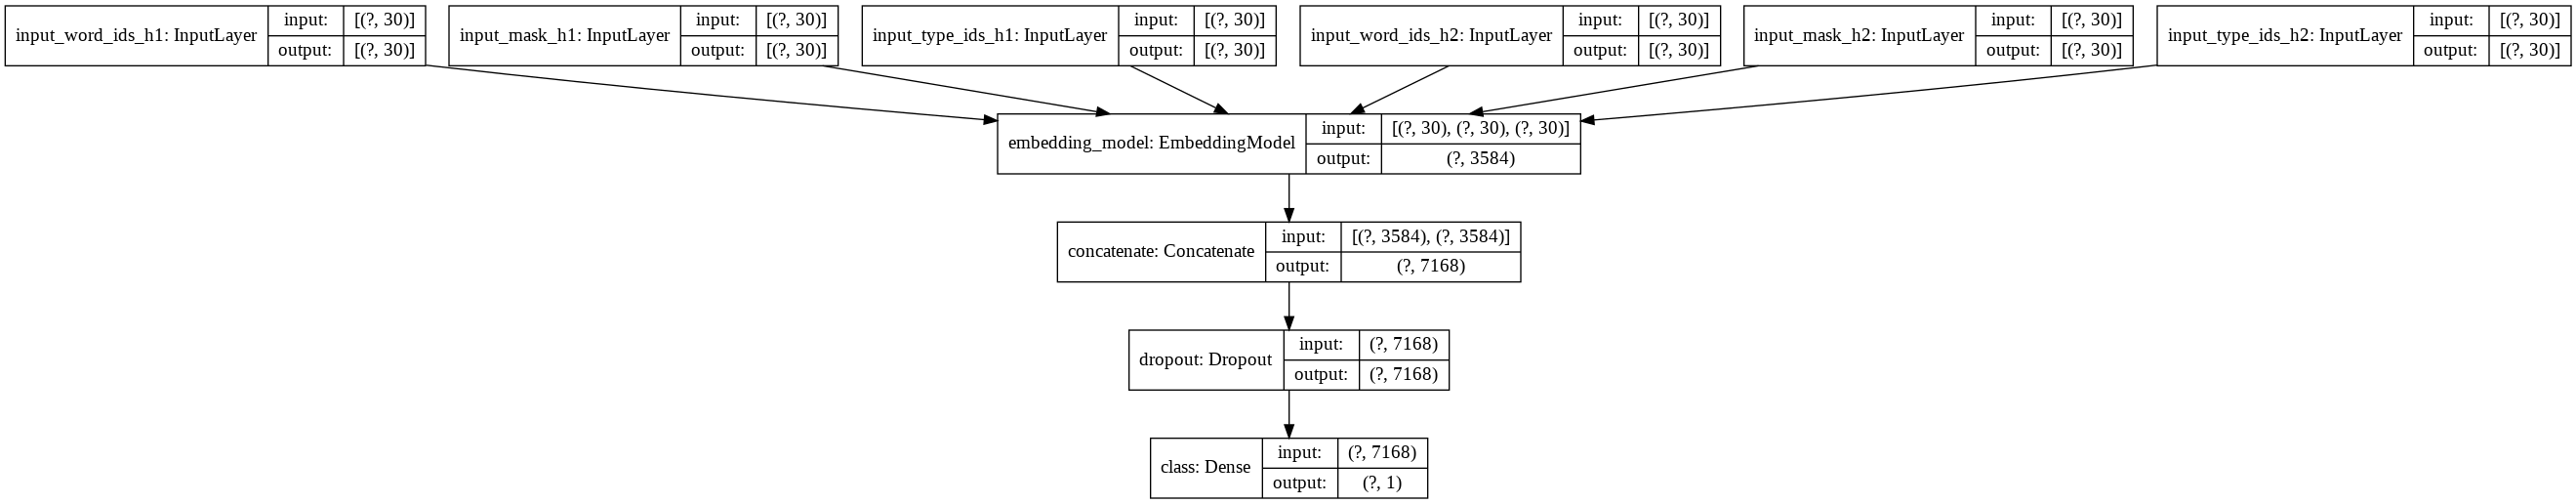

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Train model
batch_sizes = {
    'train': 2048,
    'val': 512,
    'test': 512
}

(train_data, val_data, test_data) = create_datasets_nf(packages_ids,
  batch_sizes=batch_sizes, classification=True, regression=False, cased=True, 
  enforced=True)

print(train_data.element_spec)
print(val_data.element_spec)
print(test_data.element_spec)

train_steps_per_epoch = len(train_package_ids) // batch_sizes["train"]
val_steps_per_epoch = len(val_package_ids) // batch_sizes["val"]
print(f"train_steps_per_epoch: {train_steps_per_epoch} ")
print(f"val_steps_per_epoch: {val_steps_per_epoch}")

Getting pipelined datasets...
({'input_word_ids_h1': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None), 'input_mask_h1': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None), 'input_type_ids_h1': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None), 'input_word_ids_h2': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None), 'input_mask_h2': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None), 'input_type_ids_h2': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None)}, TensorSpec(shape=(2048,), dtype=tf.int32, name=None))
({'input_word_ids_h1': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), 'input_mask_h1': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), 'input_type_ids_h1': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), 'input_word_ids_h2': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), 'input_mask_h2': TensorSpec(shape=(None, 30), dtype=tf.int32, name=None), 'input_type_ids_h2': TensorSpec(shape=(None, 30), dtype=tf.int32, nam

In [ ]:
# for x,*y in test_data.take(1).as_numpy_iterator():
#   print(model.predict(x))

In [ ]:
epochs = 100

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

hostory = model.fit(train_data, 
                    epochs=epochs,
                    steps_per_epoch= train_steps_per_epoch,
                    validation_data= val_data, 
                    validation_steps = val_steps_per_epoch,
                    callbacks =  [early_stopping],
                    verbose=1)

Epoch 1/100
4/4 [==============================] - 53s 13s/step - loss: 1.1593 - binary_accuracy: 0.5054 - val_loss: 1.0128 - val_binary_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 54s 13s/step - loss: 0.8677 - binary_accuracy: 0.4961 - val_loss: 0.7006 - val_binary_accuracy: 0.4873
Epoch 3/100
4/4 [==============================] - 53s 13s/step - loss: 0.6987 - binary_accuracy: 0.5110 - val_loss: 0.6994 - val_binary_accuracy: 0.5098
Epoch 4/100
4/4 [==============================] - 54s 13s/step - loss: 0.7021 - binary_accuracy: 0.5044 - val_loss: 0.6968 - val_binary_accuracy: 0.5010
Epoch 5/100
4/4 [==============================] - 52s 13s/step - loss: 0.6961 - binary_accuracy: 0.5109 - val_loss: 0.6958 - val_binary_accuracy: 0.5039
Epoch 6/100
4/4 [==============================] - 53s 13s/step - loss: 0.6946 - binary_accuracy: 0.5109 - val_loss: 0.6917 - val_binary_accuracy: 0.5039
Epoch 7/100
4/4 [==============================] - 52s 13s/step - loss: 0.69

[]

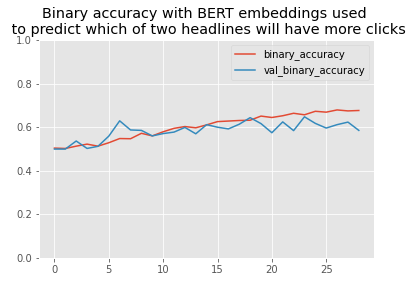

In [ ]:
pd.DataFrame(hostory.history)[["binary_accuracy", "val_binary_accuracy"]].plot()
plt.ylim((0,1))
plt.title("Binary accuracy with BERT embeddings used \n to predict which of two headlines will have more clicks")
plt.plot()

In [ ]:
model.evaluate(test_data, batch_size=batch_sizes["test"], steps=len(test_package_ids) // len(test_package_ids))

1/1 [==============================] - 0s 2ms/step - loss: 0.6904 - binary_accuracy: 0.5273


[0.6903924942016602, 0.52734375]

In [ ]:
from IPython.display import display
num_trials = 100
idxs = np.random.choice(len(test_package_ids), num_trials)
correct_answers = 0

for idx in idxs:
  sub_df = df[df.clickability_test_id == test_package_ids[idx]].head(2)
  h1, h2 = sub_df["headline_lowercase"].values
  c1, c2 = sub_df["clicks"].values
  test_sample = tf.data.Dataset.from_tensors((h1, h2, -1, int(c1 > c2)))
  test_sample = test_sample.map(to_feature_map).batch(1)
  print(f"Headlines:\nh1: {h1}\nh2: {h2}")
  print(f"h1 clicks: {c1}\nh2 clicks: {c2}")
  for x, y in test_sample:
    y_true_label = "will have more clicks" if y == 1 else "Will have lesser clicks" 
    y_pred = model.predict(x)
    y_pred_label = "will have more clicks" if y_pred > 0.5 else "Will have lesser clicks " 
    y_predicted = y_pred > 0.5
    if y_predicted == y:
      correct_answers+=1
    print(f"Raw prediction: {y_pred}")
    print(f"Raw target: {y}")
    print(f"Intuitive predicton: {y_pred_label}")
    print(f"Intuitive target   : {y_true_label}")
    print()
print(f"Accuracy: {correct_answers/num_trials}")

Headlines:
h1: studies now say there’s nothing wrong with artificial sweeteners. (head spins around.)
h2: put down that diet soda. no, wait. false alarm. go ahead and have one on me.
h1 clicks: 21
h2 clicks: 35
Raw prediction: [[0.5005618]]
Raw target: [0]
Intuitive predicton: will have more clicks
Intuitive target   : Will have lesser clicks

Headlines:
h1: the oscars have been singing this song to themselves for decades. she's singing it out loud.
h2: neil patrick harris is a tv and broadway star hosting the oscars. she's suggesting a musical number.
h1 clicks: 28
h2 clicks: 17
Raw prediction: [[0.83906513]]
Raw target: [1]
Intuitive predicton: will have more clicks
Intuitive target   : will have more clicks

Headlines:
h1: adorable couple + even more adorable-er song for their future child = 3 minutes of pure delight.
h2: cute couple + even cuter song for their future child = 3 minutes of pure delight.
h1 clicks: 19
h2 clicks: 14
Raw prediction: [[0.42100707]]
Raw target: [1]
Intuit

# Including new features

## Data prep

In [ ]:
def get_datasets(train_package_ids, val_package_ids, test_package_ids, one_hot=False,
                 classification=True, regression=False, sorted=False, features=None, 
                 cased=False, enforced=False):
  kwargs = {
    "one_hot": one_hot,
    "classification": classification,
    "regression": regression,
    "sorted": sorted,
    "features" : features,
    "cased":cased,
    "enforced":enforced
  }

  with tf.device("/cpu:0"):
    
    def train_generator():
      return single_data_generator(train_package_ids, **kwargs)
    
    def val_generator():
      return single_data_generator(val_package_ids, **kwargs)

    def test_generator():
      return single_data_generator(test_package_ids, **kwargs)
    if features != None:
      output_types = [tf.string] + [tf.float32] * len(features) + [tf.string] + \
                   [tf.float32]*len(features) + [tf.float32, tf.int32] 
      output_types = tuple(output_types)
    else:
      output_types = (tf.string, tf.string, tf.float32, tf.int32)
    train_data = tf.data.Dataset.from_generator(train_generator, output_types)
    val_data = tf.data.Dataset.from_generator(val_generator, output_types)
    test_data = tf.data.Dataset.from_generator(test_generator, output_types)
  return (train_data, val_data, test_data)

In [ ]:
(train_data, val_data, test_data) = get_datasets(train_package_ids, val_package_ids, 
                                                 test_package_ids, 
                                                 classification = False, 
                                                 regression = True, 
                                                 enforced=True,
                                                 features=features)
for xsys in zip(train_data.take(1).as_numpy_iterator(), val_data.take(1).as_numpy_iterator(), test_data.take(1).as_numpy_iterator()):
  list(map(lambda xy, title: print(f"{title} sample batch: {xy}"), *[xsys, ["Train", "Validation", "Test"]]))

Train sample batch: (b'tobacco companies would really prefer you didn\xe2\x80\x99t know these 9 things about cigarettes', 0.006886065, 4.0, 5.0, 0.0, 1.0, 0.42, 0.39, 0.28, 0.54, 0.0, 0.26, 0.34, 0.44, 0.54, 0.44, b"it's kinda crazy that tobacco companies are allowed to make these 9 changes to cigarettes", 0.001704514, 4.0, 2.0, 1.0, 0.0, 0.45, 0.49, 0.13, 0.52, 0.05, 0.26, 0.31, 0.42, 0.46, 0.87, 0.3783784, -1)
Validation sample batch: (b"ferguson has taught us many things. here's the most important one.", 0.9994073, 4.0, 1.0, 2.0, 1.0, 0.32, 0.38, 0.33, 0.47, 0.17, 0.36, 0.37, 0.28, 0.69, 0.46, b'a pen, paper, and watercolors tell one of the most tragic stories in recent american history', 0.99734265, 2.0, 1.0, 3.0, 2.0, 0.37, 0.49, 0.22, 0.44, 0.01, 0.18, 0.44, 0.44, 0.63, 0.27, 0.2857143, -1)
Test sample batch: (b"'her pancreas is dead, and it died all of the sudden. it becomes very life threatening, very fast.'", 2.5987625e-05, 4.0, 3.0, 2.0, 0.0, 0.38, 0.26, 0.0, 0.0, 0.0, 0.0, 0

In [ ]:
def split_inputs(args_inputs):
  headline1 = args_inputs[0]
  additional_features1 = list(args_inputs[1:1+len(features)])
  headline2 = args_inputs[1+len(features)]
  additional_features2 = list(args_inputs[len(features)+2: 2*len(features)+2])
  regression_target, class_label = args_inputs[-2]
  return headline1, additional1, headline2,additional_features2, regression_target, class_label

In [ ]:
from tensorflow.data.experimental import AUTOTUNE

def get_pipelined_datasets(datasets, batch_sizes):
  if type(batch_sizes) == int:
    train_bs = val_bs = test_bs = batch_sizes
  elif type(batch_sizes) == dict:
    train_bs = batch_sizes["train"]
    val_bs = batch_sizes["val"]
    test_bs = batch_sizes["test"]
  
  # print(f"train_bs: {train_bs}\nval_bs: {val_bs}\ntest_bs: {test_bs}")
  def get_bert_tokens(*x):
    bert_inputs, target = to_feature_map(x[0], x[len(features)+1], x[-2], x[-1])
    additional_features1 = tf.concat(x[1:len(features)+1], axis=0) 
    additional_features2 = tf.concat(x[len(features)+2:-2], axis=0)
    additional_features1.set_shape((len(features),))
    additional_features2.set_shape((len(features),))
    
    add_features = {
        "additional_features1" : additional_features1, 
        "additional_features2": additional_features2
    }
    return {**add_features, **bert_inputs}, target

  train_data, val_data, test_data = datasets
  with tf.device('/cpu:0'):
    # train
    train_data = (train_data.map(get_bert_tokens,
                                num_parallel_calls = AUTOTUNE)
    .shuffle(1000)
    .batch(train_bs, drop_remainder=True)
    .prefetch(AUTOTUNE))

    # valid
    val_data = (val_data.map(get_bert_tokens,
                                num_parallel_calls = AUTOTUNE)
    .batch(val_bs)
    .prefetch(AUTOTUNE))

    # valid
    test_data = (test_data.map(get_bert_tokens,
                                num_parallel_calls = AUTOTUNE)
    .batch(test_bs)
    .prefetch(AUTOTUNE))

  return train_data, val_data, test_data

In [ ]:
from tensorflow.data.experimental import AUTOTUNE

def create_datasets(packages_ids, batch_size=1024, batch_sizes=None, one_hot=False, 
                    classification=True, regression=True, train_portion=0.8, 
                    val_portion=0.1, test_portion=0.1, sorted=False, features=None, 
                    cased=False, enforced=True):
  kwargs = {
    "one_hot": one_hot,
    "classification": classification,
    "regression": regression,  
    "sorted": sorted,
    "features": features,
    "cased": cased,
    "enforced": enforced
  }

  if batch_sizes == None:
    batch_sizes = batch_size
  elif type(batch_sizes) == dict:
    try:
      train_bs = batch_sizes["train"]
      val_bs = batch_sizes["val"]
      test_bs = batch_sizes["test"]
    except KeyError as e:
      raise KeyError("Valid keys are: 'train', 'val' and 'test'")

  # Datasets partitioning
  train_samples, val_samples, test_samples = list(
      map(
          lambda x : int(x * len(packages_ids)), 
          (train_portion, val_portion, test_portion))
  ) 

  train_package_ids = packages_ids[:train_samples]
  val_package_ids = packages_ids[train_samples:train_samples+val_samples]
  test_package_ids = packages_ids[-test_samples:]

  datasets = get_datasets(train_package_ids, val_package_ids, 
                          test_package_ids, **kwargs)
  print(f"Getting pipelined datasets...")
  datasets = get_pipelined_datasets(datasets, batch_sizes)
  return datasets

In [ ]:
(train_ds, val_ds, test_ds) = create_datasets(packages_ids, features=features, batch_size=1)

Getting pipelined datasets...


In [ ]:
for x in train_ds.take(1).as_numpy_iterator():
  print(x)

({'additional_features1': array([[1.9687414e-04, 8.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 4.6000001e-01, 4.4000000e-01, 1.4000000e-01,
        5.0000000e-01, 0.0000000e+00, 2.0000000e-02, 3.6000001e-01,
        9.9999998e-03, 5.0999999e-01, 2.5999999e-01]], dtype=float32), 'additional_features2': array([[0.95070875, 6.        , 2.        , 1.        , 2.        ,
        0.1       , 0.6       , 0.        , 0.03      , 0.        ,
        0.        , 0.33      , 0.01      , 0.37      , 0.        ]],
      dtype=float32), 'input_word_ids_h1': array([[  101,  8801,  2024,  2437,  2009,  6211,  2005,  2023,  2177,
         2000,  3789,  1012,  1017,  2616,  1012, 24468,  2007,  1005,
         1038, 10559, 10814,  1997,  1038,  4135, 10626,  1012,  1005,
          102,     0,     0]], dtype=int32), 'input_mask_h1': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 0]], dtype=int32), 'input_type_ids_h1': array([[

## Model creation

In [ ]:
class EmbeddingModel2(tf.keras.Model):
  def __init__(self, feature_dim, bert_layer=bert_layer, finetune=False):
    super(EmbeddingModel2, self).__init__(name="")
    self.bert_layer = bert_layer
    if finetune:
      self.bert_layer.trainable = True
    self.feature_dim = feature_dim
    self.conv1d = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation="relu") 
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(self.feature_dim, activation=None)
    self.normalize = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x))
    self.dropout1 =  tf.keras.layers.Dropout(0.2)
    self.concat = tf.keras.layers.Concatenate()

  def call(self, inputs):
    # inputs = [input_word_ids, input_mask, input_type_ids]
    pooled_output, sequence_ouput = self.bert_layer(inputs)
    # pooled_output = [batch_size, 768]
    # sequence_ouput = [batch_size, seq_length, 768]
    seq = self.conv1d(sequence_ouput)
    seq = self.flatten(seq)
    return seq

In [ ]:
# Building the model
def create_model(name, embedding_model):
  tf.keras.backend.clear_session()

  input_word_ids_h1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids_h1")
  input_mask_h1 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask_h1")
  input_type_ids_h1 = tf.keras. layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_type_ids_h1")
  
  additional_features1 = tf.keras.layers.Input(shape=(len(features),), dtype=tf.float32, 
                                               name="additional_features1")

  additional_features2 = tf.keras.layers.Input(shape=(len(features),), dtype=tf.float32, 
                                               name="additional_features2")
  
  input_word_ids_h2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids_h2")
  input_mask_h2 = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_mask_h2")
  input_type_ids_h2 = tf.keras. layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_type_ids_h2")
  
  embeddings_h1 = embedding_model([input_word_ids_h1, input_mask_h1, input_type_ids_h1])

  embeddings_h2 = embedding_model([input_word_ids_h2, input_mask_h2, input_type_ids_h2])

  embeddings_concat = tf.keras.layers.Concatenate()([embeddings_h1, embeddings_h2])

  features_concat = tf.keras.layers.Concatenate()([additional_features1, additional_features2])

  dropout1 = tf.keras.layers.Dropout(0.5)(embeddings_concat)

  additional_features_out = tf.keras.layers.Dense(20, activation="relu")(features_concat)

  pre_output = tf.keras.layers.Concatenate()([additional_features_out, dropout1])

  # output_regression = tf.keras.layers.Dense(1, activation="linear", name="reg")(dropout1)

  output_classification = tf.keras.layers.Dense(1, activation="sigmoid", name="class")(pre_output)

  model = tf.keras.Model(inputs = {
      "additional_features1": additional_features1,
      "additional_features2":additional_features2,
      "input_word_ids_h1": input_word_ids_h1,
      "input_mask_h1": input_mask_h1, 
      "input_type_ids_h1" : input_type_ids_h1,
      "input_word_ids_h2": input_word_ids_h2,
      "input_mask_h2": input_mask_h2, 
      "input_type_ids_h2" : input_type_ids_h2,
  }, outputs=output_classification, name=name)
  return model

In [ ]:
embedding_model = EmbeddingModel2(feature_dim=1024)
model2 = create_model("bert_model_embeddings2", embedding_model)

In [ ]:
model2.summary()

Model: "bert_model_embeddings2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids_h1 (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_mask_h1 (InputLayer)      [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_type_ids_h1 (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_word_ids_h2 (InputLayer)  [(None, 30)]         0                                            
_____________________________________________________________________________

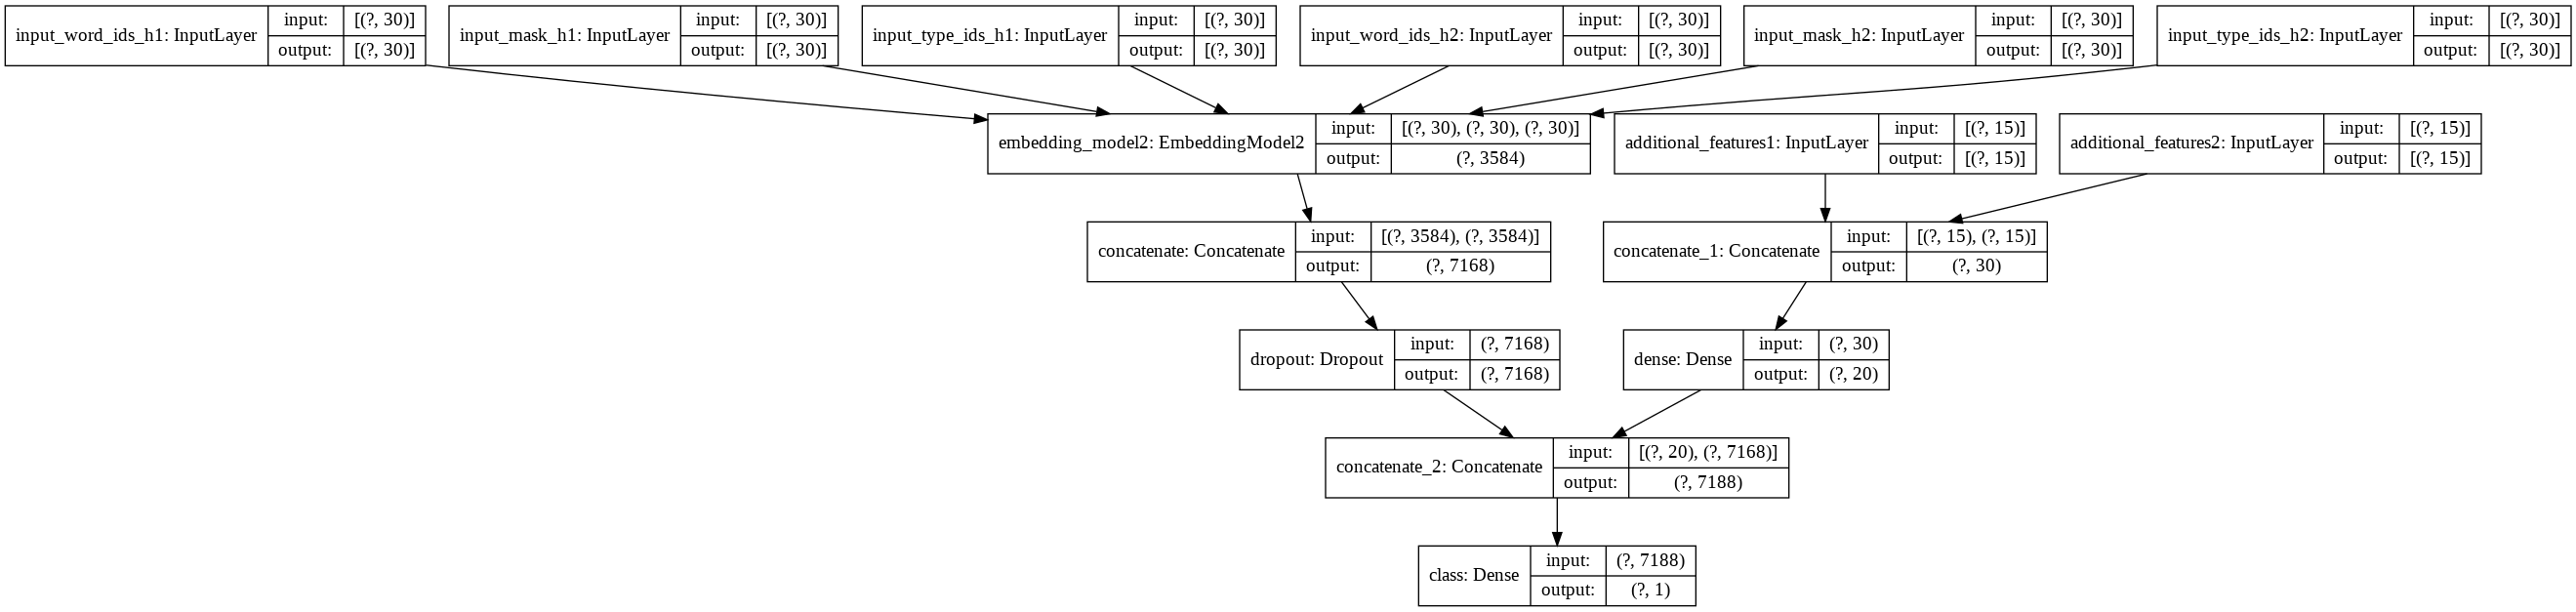

In [ ]:
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
x,y = next(iter(train_ds.take(1).as_numpy_iterator()))
model2.predict(x)

array([[0.13516827]], dtype=float32)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss="bce", metrics=["acc"])

In [ ]:
# Train model
batch_sizes = {
    'train': 2048,
    'val': 512,
    'test': 512
}

(train_data, val_data, test_data) = create_datasets(packages_ids, features=features, 
                                                    batch_sizes=batch_sizes, enforced=True,
                                                    regression=False, classification=True)
pprint(train_data.element_spec)

train_steps_per_epoch = len(train_package_ids) // batch_sizes["train"]
val_steps_per_epoch = len(val_package_ids) // batch_sizes["val"]
print(f"train_steps_per_epoch: {train_steps_per_epoch} ")
print(f"val_steps_per_epoch: {val_steps_per_epoch}")

Getting pipelined datasets...
({'additional_features1': TensorSpec(shape=(2048, 15), dtype=tf.float32, name=None),
  'additional_features2': TensorSpec(shape=(2048, 15), dtype=tf.float32, name=None),
  'input_mask_h1': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None),
  'input_mask_h2': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None),
  'input_type_ids_h1': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None),
  'input_type_ids_h2': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None),
  'input_word_ids_h1': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None),
  'input_word_ids_h2': TensorSpec(shape=(2048, 30), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2048,), dtype=tf.int32, name=None))
train_steps_per_epoch: 4 
val_steps_per_epoch: 2


In [ ]:
epochs = 100

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

hostory = model2.fit(train_data, 
                    epochs=epochs,
                    steps_per_epoch= train_steps_per_epoch,
                    validation_data= val_data, 
                    validation_steps = val_steps_per_epoch,
                    callbacks =  [early_stopping],
                    verbose=1)

Epoch 1/100
4/4 [==============================] - 59s 15s/step - loss: 1.1673 - acc: 0.5020 - val_loss: 0.7418 - val_acc: 0.5049
Epoch 2/100
4/4 [==============================] - 57s 14s/step - loss: 0.7845 - acc: 0.4995 - val_loss: 0.7207 - val_acc: 0.5020
Epoch 3/100
4/4 [==============================] - 58s 14s/step - loss: 0.7027 - acc: 0.5184 - val_loss: 0.6919 - val_acc: 0.5176
Epoch 4/100
4/4 [==============================] - 57s 14s/step - loss: 0.6905 - acc: 0.5339 - val_loss: 0.6923 - val_acc: 0.5361
Epoch 5/100
4/4 [==============================] - 58s 14s/step - loss: 0.6888 - acc: 0.5476 - val_loss: 0.6895 - val_acc: 0.5449
Epoch 6/100
4/4 [==============================] - 57s 14s/step - loss: 0.6873 - acc: 0.5481 - val_loss: 0.6871 - val_acc: 0.5537
Epoch 7/100
4/4 [==============================] - 58s 15s/step - loss: 0.6836 - acc: 0.5670 - val_loss: 0.6825 - val_acc: 0.5742
Epoch 8/100
4/4 [==============================] - 57s 14s/step - loss: 0.6812 - acc: 0.56

<AxesSubplot:>

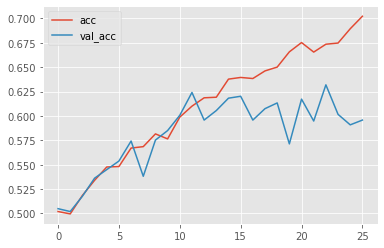

In [ ]:
pd.DataFrame(hostory.history)[["acc","val_acc"]].plot()

In [ ]:
model2.evaluate(test_data, batch_size=batch_sizes["test"], steps = (len(test_package_ids) // len(test_package_ids))*2)

2/2 [==============================] - 4s 2s/step - loss: 0.6959 - acc: 0.6016


[0.6959366202354431, 0.6015625]

# Lista de cosas a mejorar

1. Extraer features adicionales del headline (número de verbos, sustantivos, entities, etc...)

2. Usar Embedding preentrenados en lugar de entrenarlos desde 0 (com0 clasificación)

3. Asignar mayores pesos a las primeras palabras de un headline

4. Restar feature embeddings de palabras distintas para dos headlines similares

5. Revisar tendencias de aplabras una semana antes de la fecha de creación de cada healdine (y quedarse con el máximo número de búsquedas)

6. Try with trends

7. Tener como input de palabras que difieren (embeddings preentrenados)

8. Intentar con topics